# Transaction simulated dataset
This section presents a transaction simulated dataset of legitimate and fraudulent transactions. 
A simulation is necessarily an approximation of reality. 
The simulated datasets will highlight most of the issues that practitioners of fraud detection face using real-world data. In particular, they will include class imbalance (less than 1% of fraudulent transactions), a mix of numerical and categorical features (with categorical features involving a very large number of values)

### Transaction features

Our focus will be on the most essential features of a transaction. In essence, a payment card transaction consists of any amount paid to a merchant by a customer at a certain time. The six main features that summarise a transaction therefore are:

    The transaction ID: A unique identifier for the transaction
    The date and time: Date and time at which the transaction occurs
    The customer ID: The identifier for the customer. Each customer has a unique identifier
    The terminal ID: The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier
    The transaction amount: The amount of the transaction.
    Transaction time in seconds: Time in seconds at which the transaction occurs	
    Transaction time in days:  Number in days on which the transaction occurs strating from zero i.e the first day of transactions by different customers
    The fraud label: A binary variable, with the value  0  for a legitimate transaction, or the value  1  for a fraudulent transaction.

These features will be referred to as TRANSACTION_ID, TX_DATETIME, CUSTOMER_ID, TERMINAL_ID, TX_AMOUNT, TX_TIME_SECONDS	TX_TIME_DAYS and TX_FRAUD.


### loading dataset
we have a transaction data of six months. starting from april to December. the data is in pickle format and is in month wise.
Let us first load the transaction data. We will load the transaction files from April to December.

The below function takes as input the folder where the data files are located, and the dates that define the period to load (between BEGIN_DATE and END_DATE). It returns a DataFrame of transactions. 

In [1]:
import os
import pandas as pd
import datetime
import time

def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    l = []
    BEGIN_DATE_file =  BEGIN_DATE+ ".csv"
    END_DATE_file = END_DATE + ".csv"
    lst = os.listdir(DIR_INPUT)
    big_index = lst.index(BEGIN_DATE_file)
    end_index = lst.index(END_DATE_file)
    for i in lst[big_index:end_index+1]:
        file = DIR_INPUT + i
        #os.path.join(DIR_INPUT, i)
        df = pd.read_csv(file)
        #df.drop(['TX_FRAUD_SCENARIO'], axis =1, inplace =True)
        if i == BEGIN_DATE_file:
            l.append(df)
        else:
            l[0]= l[0].append(df,ignore_index=True)
    df_final =l[0]  
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
        
        
    return df_final


In [ ]:
#loading six months data.

In [2]:
BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"
DIR_INPUT='Training_Batch_Files/' 
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
transactions_df['TX_DATETIME']  = transactions_df.TX_DATETIME.astype("<M8[ns]")
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Wall time: 29.6 s
1754155 transactions loaded, containing 14681 fraudulent transactions


In [3]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0


In [4]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   TRANSACTION_ID   int64         
 1   TX_DATETIME      datetime64[ns]
 2   CUSTOMER_ID      int64         
 3   TERMINAL_ID      int64         
 4   TX_AMOUNT        float64       
 5   TX_TIME_SECONDS  int64         
 6   TX_TIME_DAYS     int64         
 7   TX_FRAUD         int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 107.1 MB


## Feature Transformation 
output feature----- TX_FRAUD

we have different type of input features
1. categorical features------TX_TIME_DAYS,CUSTOMER_ID,TERMINAL_ID	
2. numerical/quantitative features--------TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
3. Datetime feature--------TX_TIME_SECONDS

In [7]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   TRANSACTION_ID   int64         
 1   TX_DATETIME      datetime64[ns]
 2   CUSTOMER_ID      int64         
 3   TERMINAL_ID      int64         
 4   TX_AMOUNT        float64       
 5   TX_TIME_SECONDS  int64         
 6   TX_TIME_DAYS     int64         
 7   TX_FRAUD         int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 107.1 MB


# Date and time transformations
We will create two new binary features from the transaction dates and times:

1. The first will characterize whether a transaction occurs during a weekday (value 0) or a weekend (1), and will be called TX_DURING_WEEKEND
2. The second will characterize whether a transaction occurs during the day or during the day (0) or during the night (1). The night is defined as hours that are between 0pm and 6am. It will be called TX_DURING_NIGHT. 

In [9]:
#weekday (value 0) or a weekend (1)
def is_weekend(tx_datetime):
    if tx_datetime.weekday()>= 5:
        return 1
    else:
        return 0

In [10]:
%time transactions_df['TX_DURING_WEEKEND'] = transactions_df.TX_DATETIME.apply(is_weekend)

Wall time: 25.6 s


In [11]:
#day (0) or during the night (1)
def is_night(tx_datetime):
    if tx_datetime.hour <= 6:
        return 1
    else:
        return 0

In [12]:
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

Wall time: 25.6 s


Let us check that these features where correctly computed.

In [13]:
transactions_df['dayname'] = transactions_df.TX_DATETIME.dt.day_name()

In [14]:
transactions_df[transactions_df.TX_TIME_DAYS>=30]

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_DURING_WEEKEND,TX_DURING_NIGHT,dayname
288062,288062,2018-05-01 00:01:21,3546,2944,18.71,2592081,30,0,0,1,Tuesday
288063,288063,2018-05-01 00:01:48,206,3521,18.60,2592108,30,0,0,1,Tuesday
288064,288064,2018-05-01 00:02:22,2610,4470,66.67,2592142,30,0,0,1,Tuesday
288065,288065,2018-05-01 00:03:15,4578,1520,79.41,2592195,30,0,0,1,Tuesday
288066,288066,2018-05-01 00:03:51,1246,7809,52.08,2592231,30,0,0,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,1,0,Sunday
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,1,0,Sunday
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,1,0,Sunday
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,1,0,Sunday


In [15]:
transactions_df.drop("dayname", axis =1 , inplace =True)

In [16]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_DURING_WEEKEND,TX_DURING_NIGHT
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,1,1
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,1,1
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,1,1
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,1,1
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,1,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,1,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,1,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,1,0


## Customer ID transformations
1. Let us now proceed with customer ID transformations.
    1. The first feature will be the number of transactions that occur within a time window (Frequency). 
    2. The second will be the average amount spent in these transactions (Monetary value). 
2. The time windows will be set to one, seven, and thirty days. This will generate six new features. 

In [17]:
def get_customer_spending_behaviour_features(dfx, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    dfx=dfx.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    dfx.index=dfx.TX_DATETIME
    
    # For each window size
    for i in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        tsum =dfx['TX_AMOUNT'].rolling(str(i)+'d').sum()
        tcount =dfx['TX_AMOUNT'].rolling(str(i)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        avg = tsum/tcount
    
        # Save feature values
        dfx['CUSTOMER_ID_NB_TX_'+str(i)+'DAY_WINDOW']=list(tcount)
        dfx['CUSTOMER_ID_AVG_AMOUNT_'+str(i)+'DAY_WINDOW']=list(avg)
    
    # Reindex according to transaction IDs
    dfx.index=dfx.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return dfx

Let us compute these aggregates for the first customer.

In [18]:
spending_behaviour_customer_0=get_customer_spending_behaviour_features(transactions_df[transactions_df.CUSTOMER_ID==0])
spending_behaviour_customer_0

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,
1758,1758,2018-04-01 07:19:05,0,6076,123.59,26345,0,0,1,0,1.0,123.590000,1.0,123.590000,1.0,123.590000
8275,8275,2018-04-01 18:00:16,0,858,77.34,64816,0,0,1,0,2.0,100.465000,2.0,100.465000,2.0,100.465000
8640,8640,2018-04-01 19:02:02,0,6698,46.51,68522,0,0,1,0,3.0,82.480000,3.0,82.480000,3.0,82.480000
12169,12169,2018-04-02 08:51:06,0,6569,54.72,118266,1,0,0,0,3.0,59.523333,4.0,75.540000,4.0,75.540000
15764,15764,2018-04-02 14:05:38,0,7707,63.30,137138,1,0,0,0,4.0,60.467500,5.0,73.092000,5.0,73.092000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750390,1750390,2018-09-30 13:38:41,0,3096,38.23,15773921,182,0,1,0,5.0,64.388000,28.0,57.306429,89.0,63.097640
1750758,1750758,2018-09-30 14:10:21,0,9441,43.60,15775821,182,0,1,0,6.0,60.923333,29.0,56.833793,89.0,62.433933
1751039,1751039,2018-09-30 14:34:30,0,1138,69.69,15777270,182,0,1,0,7.0,62.175714,29.0,57.872414,90.0,62.514556


In [19]:
spending_behaviour_customer_0[['TX_DATETIME', 'TX_AMOUNT','CUSTOMER_ID_NB_TX_1DAY_WINDOW','CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW']][:20]

,TX_DATETIME,TX_AMOUNT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW
TRANSACTION_ID,,,,
1758,2018-04-01 07:19:05,123.59,1.0,123.590000
8275,2018-04-01 18:00:16,77.34,2.0,100.465000
8640,2018-04-01 19:02:02,46.51,3.0,82.480000
12169,2018-04-02 08:51:06,54.72,3.0,59.523333
15764,2018-04-02 14:05:38,63.30,4.0,60.467500
16470,2018-04-02 15:13:02,32.35,5.0,54.844000
16810,2018-04-02 15:46:51,13.59,6.0,47.968333
18572,2018-04-02 20:24:47,51.89,5.0,43.170000
21219,2018-04-03 07:41:24,93.26,6.0,51.518333


Let us now generate these features for all customers. This is straightforward using the Panda groupby and apply methods.

In [20]:
%time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))

Wall time: 1min 39s


In [21]:
transactions_df

TRANSACTION_ID         TX_DATETIME  CUSTOMER_ID  \
CUSTOMER_ID TRANSACTION_ID                                                    
0           1758                      1758 2018-04-01 07:19:05            0   
            8275                      8275 2018-04-01 18:00:16            0   
            8640                      8640 2018-04-01 19:02:02            0   
            12169                    12169 2018-04-02 08:51:06            0   
            15764                    15764 2018-04-02 14:05:38            0   
...                                    ...                 ...          ...   
4999        1739959                1739959 2018-09-29 12:12:38         4999   
            1742880                1742880 2018-09-29 17:06:15         4999   
            1745242                1745242 2018-09-30 04:32:41         4999   
            1746723                1746723 2018-09-30 08:07:27         4999   
            1753338                1753338 2018-09-30 19:12:37         4999   

                            TERMINAL_ID  TX_AMOUNT  TX_TIME_SECONDS  \
CUSTOMER_ID TRANSACTION_ID                                            
0           1758                   6076     123.59            26345   
            8275                    858      77.34            64816   
            8640                   6698      46.51            68522   
            12169                  6569      54.72           118266   
            15764                  7707      63.30           137138   
...                                 ...        ...              ...   
4999        1739959                1804      28.68         15682358   
            1742880                8677       5.65         15699975   
            1745242                6500      52.18         15741161   
            1746723                2251      14.96         15754047   
            1753338                1880      38.50         15793957   

                            TX_TIME_DAYS  TX_FRAUD  TX_DURING_WEEKEND  \
CUSTOMER_ID TRANSACTION_ID                                              
0           1758                       0         0                  1   
            8275                       0         0                  1   
            8640                       0         0                  1   
            12169                      1         0                  0   
            15764                      1         0                  0   
...                                  ...       ...                ...   
4999        1739959                  181         0                  1   
            1742880                  181         0                  1   
            1745242                  182         0                  1   
            1746723                  182         0                  1   
            1753338                  182         0                  1   

                            TX_DURING_NIGHT  CUSTOMER_ID_NB_TX_1DAY_WINDOW  \
CUSTOMER_ID TRANSACTION_ID                                                   
0           1758                          0                            1.0   
            8275                          0                            2.0   
            8640                          0                            3.0   
            12169                         0                            3.0   
            15764                         0                            4.0   
...                                     ...                            ...   
4999        1739959                       0                            5.0   
            1742880                       0                            5.0   
            1745242                       1                            5.0   
            1746723                       0                            4.0   
            1753338                       0                            3.0   

                            CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW  \
CUSTOMER_ID TRANSACTION_ID                   

In [22]:
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

In [23]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,1,1,1.0,57.160000,1.0,57.160000,1.0,57.160000
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,1,1,1.0,81.510000,1.0,81.510000,1.0,81.510000
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,1,1,1.0,146.000000,1.0,146.000000,1.0,146.000000
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,1,1,1.0,64.490000,1.0,64.490000,1.0,64.490000
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,1,1,1.0,50.990000,1.0,50.990000,1.0,50.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,1,0,2.0,75.280000,12.0,67.047500,72.0,69.521111
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,1,0,1.0,1.230000,21.0,22.173810,93.0,24.780753
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,1,0,5.0,7.368000,21.0,7.400476,65.0,7.864462
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,1,0,3.0,100.696667,16.0,107.052500,51.0,102.919608


Terminal ID transformations
1. The main goal will be to extract a risk score, that assesses the exposure of a given terminal ID to fraudulent transactions. 
3. The risk score will be defined as the average number of fraudulent transactions that occurred on a terminal ID over a time window. As for customer ID transformations, we will use three window sizes, of 1, 7, and 30 days.

Contrary to customer ID transformations, the time windows will not directly precede a given transaction. Instead, they will be shifted back by a delay period. The delay period accounts for the fact that, in practice, the fraudulent transactions are only discovered after a fraud investigation or a customer complaint. Hence, the fraudulent labels, which are needed to compute the risk score, are only available after this delay period. To a first approximation, this delay period will be set to one week. The motivations for the delay period will be further argued in Chapter 5, Validation strategies.

Let us perform the computation of the risk scores by defining a get_count_risk_rolling_window function. The function takes as inputs the DataFrame of transactions for a given terminal ID, the delay period, and a list of window sizes. In the first stage, the number of transactions and fraudulent transactions are computed for the delay period (NB_TX_DELAY and NB_FRAUD_DELAY). In the second stage, the number of transactions and fraudulent transactions are computed for each window size plus the delay period (NB_TX_DELAY_WINDOW and NB_FRAUD_DELAY_WINDOW). The number of transactions and fraudulent transactions that occurred for a given window size, shifted back by the delay period, is then obtained by simply computing the differences of the quantities obtained for the delay period, and the window size plus delay period:

NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
The risk score is finally obtained by computing the proportion of fraudulent transactions for each window size (or 0 if no transaction occurred for the given window):

RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
Additionally to the risk score, the function also returns the number of transactions for each window size. This results in the addition of six new features: The risk and number of transactions, for three window sizes.

In [24]:
def get_count_risk_rolling_window(dfx, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    dfx=dfx.sort_values('TX_DATETIME')
    
    dfx.index=dfx.TX_DATETIME
    
    NB_FRAUD_DELAY=dfx['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=dfx['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for i in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=dfx['TX_FRAUD'].rolling(str(delay_period+i)+'d').sum()
        NB_TX_DELAY_WINDOW=dfx['TX_FRAUD'].rolling(str(delay_period+i)+'d').count()
    
        NB_FRAUD_WINDOW    =   NB_FRAUD_DELAY_WINDOW - NB_FRAUD_DELAY
        NB_TX_WINDOW       =   NB_TX_DELAY_WINDOW - NB_TX_DELAY
    
        RISK_WINDOW= NB_FRAUD_WINDOW / NB_TX_WINDOW
        
        dfx[feature+'_NB_TX_'+str(i)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        dfx[feature+'_RISK_'+str(i)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    dfx.index=dfx.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    dfx.fillna(0,inplace=True)
    

    return dfx

In [25]:
# Get the first terminal ID that contains frauds
transactions_df[transactions_df.TX_FRAUD==0].TERMINAL_ID[0]

3156

In [27]:
get_count_risk_rolling_window(transactions_df[transactions_df.TERMINAL_ID==3059], delay_period=7, windows_size_in_days=[1,7,30])[:20]

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_DURING_WEEKEND,TX_DURING_NIGHT,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,,
3527,3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,1,0,...,3.0,158.073333,3.0,158.073333,0.0,0.0,0.0,0.000000,0.0,0.000000
4732,4732,2018-04-01 11:59:14,55,3059,36.28,43154,0,0,1,0,...,2.0,35.670000,2.0,35.670000,0.0,0.0,0.0,0.000000,0.0,0.000000
16216,16216,2018-04-02 14:47:34,4879,3059,105.00,139654,1,0,0,0,...,10.0,76.010000,10.0,76.010000,0.0,0.0,0.0,0.000000,0.0,0.000000
18249,18249,2018-04-02 19:08:10,2263,3059,90.89,155290,1,0,0,0,...,7.0,50.458571,7.0,50.458571,0.0,0.0,0.0,0.000000,0.0,0.000000
26512,26512,2018-04-03 15:44:49,4879,3059,58.51,229489,2,0,0,0,...,14.0,71.070000,14.0,71.070000,0.0,0.0,0.0,0.000000,0.0,0.000000
29143,29143,2018-04-04 02:47:50,380,3059,14.86,269270,3,0,0,1,...,10.0,47.571000,10.0,47.571000,0.0,0.0,0.0,0.000000,0.0,0.000000
31121,31121,2018-04-04 08:14:29,2508,3059,20.44,288869,3,0,0,0,...,6.0,34.176667,6.0,34.176667,0.0,0.0,0.0,0.000000,0.0,0.000000
32815,32815,2018-04-04 10:49:58,1783,3059,13.04,298198,3,0,0,0,...,14.0,81.404286,14.0,81.404286,0.0,0.0,0.0,0.000000,0.0,0.000000
43721,43721,2018-04-05 12:39:28,1769,3059,48.79,391168,4,0,0,0,...,11.0,77.927273,11.0,77.927273,0.0,0.0,0.0,0.000000,0.0,0.000000


We can check that the first fraud occurred on the 2018/09/10, and that risk scores only start being counted with a one-week delay.

Let us finally generate these features for all terminals. This is straightforward using the Panda groupby and apply methods.

In [28]:
%time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)


Wall time: 4min 11s


In [30]:
transactions_df.to_csv("credit data final clean.csv")

In [31]:
DIR_OUTPUT = "./simulated-data-transformedd/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

## statistical analysis of the transaction data

Let us load the transactions from the 2018-07-25 to the 2018-08-14, and plot the number of transactions per day, fraudulent transactions per day, and fraudulent cards per day.

In [8]:
BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"
DIR_INPUT='simulated-data-transformedd/' 
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
transactions_df['TX_DATETIME']  = transactions_df.TX_DATETIME.astype("<M8[ns]")
print("Load  files")
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


Wall time: 2.39 s
Load  files
201295 transactions loaded, containing 1792 fraudulent transactions


In [9]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_DURING_WEEKEND,TX_DURING_NIGHT,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,1102483,2018-07-25 00:00:29,1111,2328,40.77,9936029,115,0,0,1,...,24.0,29.191250,105.0,30.141810,1.0,0.0,10.0,0.0,32.0,0.0
1,1102484,2018-07-25 00:01:08,676,6846,9.62,9936068,115,0,0,1,...,15.0,19.151333,61.0,18.253607,2.0,0.0,5.0,0.0,27.0,0.0
2,1102485,2018-07-25 00:01:35,402,4771,81.55,9936095,115,0,0,1,...,11.0,183.875455,50.0,112.001800,0.0,0.0,12.0,0.0,37.0,0.0
3,1102486,2018-07-25 00:01:43,4218,863,23.10,9936103,115,0,0,1,...,24.0,21.201667,93.0,19.987849,2.0,0.0,6.0,0.0,22.0,0.0
4,1102487,2018-07-25 00:02:26,3711,3599,59.25,9936146,115,0,0,1,...,27.0,80.427407,110.0,74.158455,1.0,0.0,10.0,0.0,38.0,0.0


In [10]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201295 entries, 0 to 201294
Data columns (total 22 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   TRANSACTION_ID                       201295 non-null  int64         
 1   TX_DATETIME                          201295 non-null  datetime64[ns]
 2   CUSTOMER_ID                          201295 non-null  int64         
 3   TERMINAL_ID                          201295 non-null  int64         
 4   TX_AMOUNT                            201295 non-null  float64       
 5   TX_TIME_SECONDS                      201295 non-null  int64         
 6   TX_TIME_DAYS                         201295 non-null  int64         
 7   TX_FRAUD                             201295 non-null  int64         
 8   TX_DURING_WEEKEND                    201295 non-null  int64         
 9   TX_DURING_NIGHT                      201295 non-null  int64         
 

In [11]:
transactions_df.shape

(201295, 22)

## getting statistics from transaction dataset
we will try to find the fraud transaction pattern with the help of our transaction data. after analysis we find out following conclusions
1. the average number of transaction per day ---10000
2. the average number of fraudulent transaction per day---85 (which is around  0.01% of the total transaction of the day)
3. the number of compromised card per day-------80

In [6]:
 #Number of transactions per day
transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()

TX_TIME_DAYS
115    9541
116    9787
117    9531
118    9496
119    9532
120    9648
121    9705
122    9552
123    9658
124    9476
125    9637
126    9527
127    9417
128    9708
129    9740
130    9641
131    9523
132    9427
133    9681
134    9504
135    9564
Name: CUSTOMER_ID, dtype: int64

In [7]:
#Number of fraudulent transactions per day
transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()

TX_TIME_DAYS
115     88
116     93
117     88
118     84
119     73
120     90
121     82
122     85
123    110
124     87
125     85
126     88
127     71
128    100
129     77
130     81
131     74
132     83
133     84
134     91
135     78
Name: TX_FRAUD, dtype: int64

In [8]:
#Number of compromised cards per day
transactions_df[transactions_df['TX_FRAUD']==1].groupby('TX_TIME_DAYS').CUSTOMER_ID.nunique()

TX_TIME_DAYS
115    76
116    87
117    82
118    72
119    62
120    79
121    69
122    70
123    98
124    74
125    74
126    79
127    64
128    91
129    70
130    72
131    69
132    80
133    79
134    78
135    70
Name: CUSTOMER_ID, dtype: int64

In [12]:
# function to get stats

def get_tx_stats(transactions_df, start_date_df="2018-04-01"):
    
    
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    
    #Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    
    #Number of compromised cards per day
    nb_compromised_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    
    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_compromised_cards_per_day":nb_compromised_cards_per_day})

    tx_stats=tx_stats.reset_index()
    
    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    
    tx_stats['tx_date']=tx_date
    
    return tx_stats

tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")


In [13]:
#getting statistical information about fraud from 3 months data
tx_stats

,TX_TIME_DAYS,nb_tx_per_day,nb_fraudulent_transactions_per_day,nb_compromised_cards_per_day,tx_date
0,115,9541,88,76,2018-07-25
1,116,9787,93,87,2018-07-26
2,117,9531,88,82,2018-07-27
3,118,9496,84,72,2018-07-28
4,119,9532,73,62,2018-07-29
5,120,9648,90,79,2018-07-30
6,121,9705,82,69,2018-07-31
7,122,9552,85,70,2018-08-01
8,123,9658,110,98,2018-08-02
9,124,9476,87,74,2018-08-03


## defing the training and test period
In a fraud detection context, the transactions of the test set occur chronologically after the transactions used for training the model.

We will use the transactions from the 2018-07-25 to the 2018-07-31 for the training set, and from the 2018-08-08 to the 2018-08-14 for the test set. One week of data will be sufficient to train a first prediction model and to assess its performance. We will later use larger periods for training and testing to evaluate how larger sets can affect the performance results.

It is worth noting that we choose our test set to take place one week after the last transaction of the training set. In a fraud detection context, this period separating the training and test set is referred to as the delay period or feedback delay. It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or genuine) is only known after a customer complaint, or thanks to the result of a fraud investigation. Therefore, in a realistic scenario,there is a delay period between the trainning and test. Setting a delay period of one week is simplistic. It assumes that the labels (fraudulent or genuine) for all transactions are known exactly one week after they occurred. This is not the case in practice, since the delay may be shorter when customers report frauds quickly, or much longer in cases where frauds remain undetected for months. The delay period is in fact a parameter in the assessment of a fraud detection model, which can be tuned during the validation stage. A one-week delay is, to a first approximation, a reasonable basis: from experience, statistics generally show that most of the feedback becomes available after a one week delay.

In [14]:
# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")

#delta train is the length of trainig period
#delta delay is the length of delay period
#delta test is the lenght of test period

delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)


print("start_date_training--->",start_date_training)
print("end_date_training----->",end_date_training)
print("\n")
print("-------------------------------------------------------")
print("delay period of 7 days from 2018-08-1 to 2018-08-07")
print("-------------------------------------------------------")
print("\n")
print("start_date_test------->",start_date_test)
print("end_date_test--------->",end_date_test)

start_date_training---> 2018-07-25 00:00:00
end_date_training-----> 2018-07-31 00:00:00


-------------------------------------------------------
delay period of 7 days from 2018-08-1 to 2018-08-07
-------------------------------------------------------


start_date_test-------> 2018-08-08 00:00:00
end_date_test---------> 2018-08-14 00:00:00


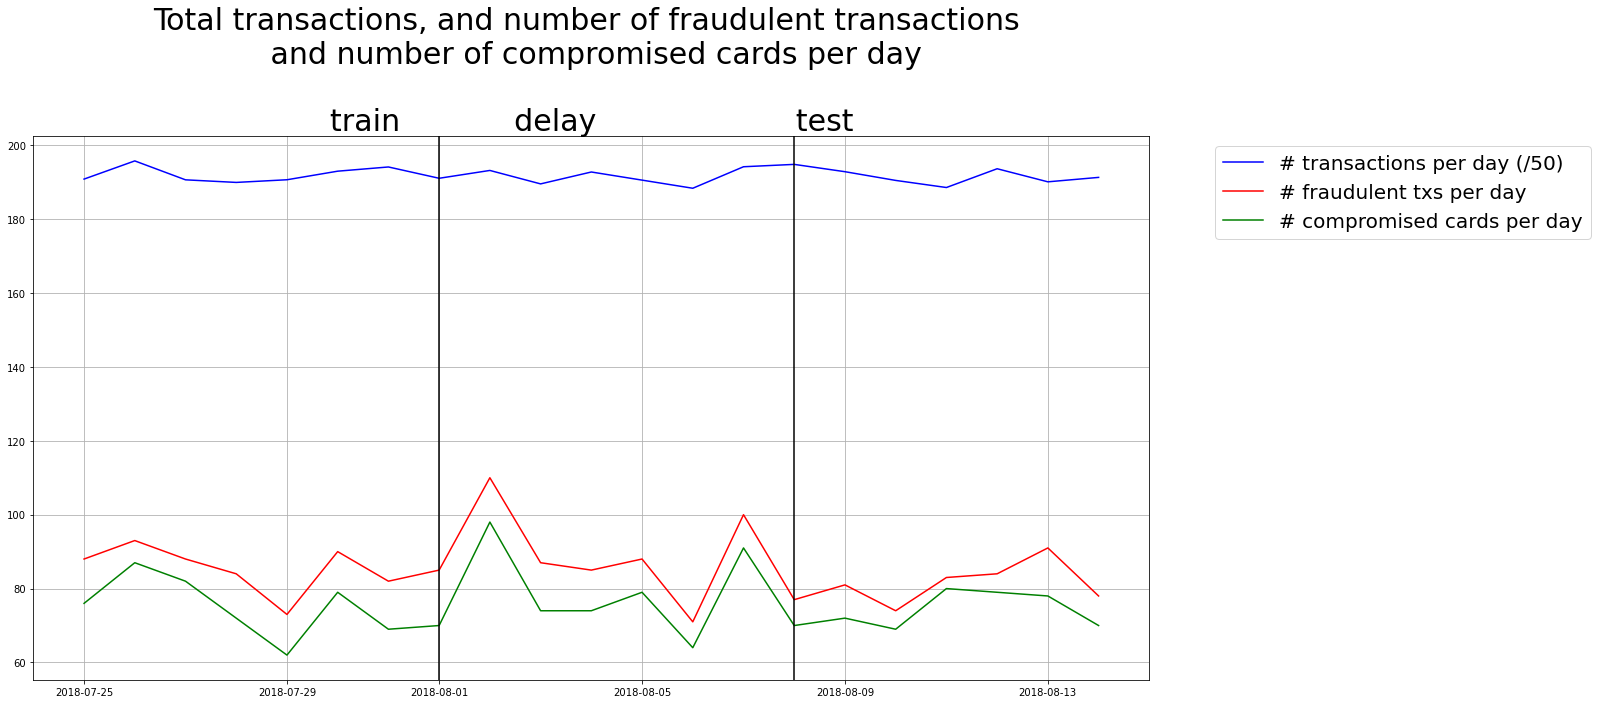

In [77]:
#visualisation 



plt.figure(figsize=(20,10))
plt.grid()
plt.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b',  label = '# transactions per day (/50)')
plt.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'r',  label = '# fraudulent txs per day')
plt.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'], 'g',  label = '# compromised cards per day')

plt.axvline(start_date_training+datetime.timedelta(days=delta_train), 0, color="black")
plt.axvline(start_date_test, 0,  color="black")
plt.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)
plt.title('Total transactions, and number of fraudulent transactions \n and number of compromised cards per day\n\ntrain            delay                     test',{'fontsize':30 })

plt.show()

The plot illustrates that the number of transactions and frauds is similar in the training and test periods. The average number of frauds is around 85 per day. Let us extract from the dataset the transactions for the training set and the test set.

## train test split

In [27]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7,
                       sampling_ratio=1.0,
                       random_state=0):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # If subsample
    if sampling_ratio<1:
        
        train_df_frauds=train_df[train_df.TX_FRAUD==1].sample(frac=sampling_ratio, random_state=random_state)
        train_df_genuine=train_df[train_df.TX_FRAUD==0].sample(frac=sampling_ratio, random_state=random_state)
        train_df=pd.concat([train_df_frauds,train_df_genuine])
        
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [28]:
(train_df, test_df)=  get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

In [85]:
train_df.shape

(67240, 22)

The trainig set contains 67240 transactions, among which 598 are fraudulent.

In [87]:
train_df[train_df.TX_FRAUD==1].shape


(598, 22)

The test set contains 58264 transactions, among which 385 are fraudulent.

In [90]:
test_df.shape

(58264, 22)

In [91]:
test_df[test_df.TX_FRAUD==1].shape


(385, 22)

That is, a proportion of 0.007 fraudulent transactions.

In [92]:
385/58264

0.00660785390635727

## model trainnig with different classifires
in the first step of model trainng we will select some classifiers and will train them using trainning data without using validation technique(we will use it later).Then we will analysis the performance and execution time of these different models using trainning and test data. 

We will define the input and output features as follows:

    1. The output feature will be the transaction label TX_FRAUD
    2. The input features will be the transaction amount TX_AMOUNT

In [21]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# libraries required

In [25]:

# General
import os
import pandas as pd
import numpy as np


import time
import pickle

import datetime


#import sklearn
import sklearn


%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

#import graphviz
import xgboost

# For imbalanced learning
#import imblearn

import warnings
warnings.filterwarnings('ignore')





from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [23]:
#we will use below functions for trainning our models and getting predictions out in the form of dictionary.

In [24]:
def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    
    return (train,test)


#model
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="TX_FRAUD",scale=True):
    if scale:
        train_df,test_df = scaleData(train_df, test_df, input_features)
    
    start_time = time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time = time.time() - start_time
    
    start_time = time.time()
    try:
        predictions_test = classifier.predict_proba(test_df[input_features])[:,1]
    except:   
        predictions_test = classifier.decision_function(test_df[input_features])
         
    prediction_execution_time = time.time() - start_time
    
    try:
        predictions_train = classifier.predict_proba(train_df[input_features])[:,1]
    except:   
        predictions_train = classifier.decision_function(train_df[input_features])
    
    y_predtrn = classifier.predict(train_df[input_features])
    y_predtst = classifier.predict(test_df[input_features])
    
    
    
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time,
                                        'predictionsclass_test': y_predtst,
                                        'predictionsclass_train':y_predtrn
                                       }
    
    
    
    return model_and_predictions_dictionary

    

In [29]:
#we will use following classifers to train our model

classifiers_dictionary={
                        'Logistic regression':LogisticRegression(random_state=42), 
                        'Decision tree': DecisionTreeClassifier(random_state=42), 
                        'SGDClassifier':SGDClassifier(random_state=42),
                        'Random forest': RandomForestClassifier(random_state=42,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=42,n_jobs=-1),
                        'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
                        'SVC' :SVC(random_state=42, probability =True)

                        
                       }



fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                                                  input_features=input_features,
                                                                                output_feature=output_feature)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions


In [30]:
#its a nested dictionay contain different models and their prediction
fitted_models_and_predictions_dictionary.keys()

dict_keys(['Logistic regression', 'Decision tree', 'SGDClassifier', 'Random forest', 'XGBoost', 'GradientBoostingClassifier', 'SVC'])

In [31]:
print(fitted_models_and_predictions_dictionary['SGDClassifier'])

{'classifier': SGDClassifier(random_state=42), 'predictions_test': array([-2.45312333, -1.99570669, -2.61181563, ..., -3.03199298,
       -1.83566002, -1.86771572]), 'predictions_train': array([-1.74353741, -2.1008742 , -1.65162189, ..., -1.90625981,
       -1.80130478, -2.37085707]), 'training_execution_time': 0.36997222900390625, 'prediction_execution_time': 0.013962507247924805, 'predictionsclass_test': array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 'predictionsclass_train': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}


In [ ]:
#below functions will use to analysis the diffenent performance of metrics of different classifers

In [32]:
def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature1='predictions',prediction_feature2='predictionsclass'):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature1])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature1])
    
    prec = precision_score(predictions_df[output_feature], predictions_df[prediction_feature2])
    recal = recall_score(predictions_df[output_feature], predictions_df[prediction_feature2]) 
    f1scor = f1_score(predictions_df[output_feature], predictions_df[prediction_feature2])
    
    performances = pd.DataFrame([[AUC_ROC, AP,prec,recal,f1scor ]], 
                           columns=['AUC ROC','Average precision','Precision', 'Recall','F1score'])
    
    return performances


def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test'
                                            ):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df.copy()
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        predictions_df['predictionsclass']=model_and_predictions['predictionsclass_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                                                   prediction_feature1='predictions',prediction_feature2='predictionsclass' )
        performances_model.index=[classifier_name]
        
        performances=performances.append(performances_model)
        
    return performances



# models performance metrics on trainnig data

In [33]:
# performances on train set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, train_df, 
                                                        type_set='train')
df_performances

,AUC ROC,Average precision,Precision,Recall,F1score
Logistic regression,0.892038,0.663478,0.904070,0.520067,0.660297
Decision tree,1.000000,1.000000,1.000000,1.000000,1.000000
SGDClassifier,0.887675,0.644250,0.911585,0.500000,0.645788
Random forest,1.000000,1.000000,1.000000,0.998328,0.999163
XGBoost,0.999927,0.994997,1.000000,0.886288,0.939716
GradientBoostingClassifier,0.952146,0.825870,0.968553,0.772575,0.859535
SVC,0.932323,0.813070,0.980501,0.588629,0.735632


# models performance metrics on test data

In [34]:
# performances on training set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test' )
                                                       
df_performances

,AUC ROC,Average precision,Precision,Recall,F1score
Logistic regression,0.870531,0.605703,0.904523,0.467532,0.616438
Decision tree,0.790420,0.307129,0.520833,0.584416,0.550796
SGDClassifier,0.867091,0.578979,0.909574,0.444156,0.596859
Random forest,0.864288,0.663395,0.965347,0.506494,0.664395
XGBoost,0.861821,0.638873,0.945455,0.540260,0.687603
GradientBoostingClassifier,0.853136,0.541597,0.840000,0.545455,0.661417
SVC,0.854442,0.637534,0.967213,0.459740,0.623239


In [35]:
def execution_times_model_collection(fitted_models_and_predictions_dictionary):

    execution_times=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        execution_times_model=pd.DataFrame() 
        execution_times_model['Training execution time']=[model_and_predictions['training_execution_time']]
        execution_times_model['Prediction execution time']=[model_and_predictions['prediction_execution_time']]
        execution_times_model.index=[classifier_name]
        
        execution_times=execution_times.append(execution_times_model)
        
    return execution_times

# trainning and prediction execution time of different classifiers

In [36]:
# Execution times
df_execution_times=execution_times_model_collection(fitted_models_and_predictions_dictionary)
df_execution_times.sort_values(['Training execution time'])

,Training execution time,Prediction execution time
SGDClassifier,0.369972,0.013963
Logistic regression,1.170929,0.028998
Decision tree,2.060894,0.033998
Random forest,10.091479,0.575968
XGBoost,10.560399,0.163989
GradientBoostingClassifier,29.285531,0.134995
SVC,186.659335,18.258052


The main takeaways in these performance results are

All prediction models have learned useful fraud patterns from the training data. This can be seen from the AUC ROC on the test set, which is higher than 0.5 for all classifiers, and an average precision much higher .
The random forest and boosting models provide better performances (in terms of Average Precision) than logistic regression and decision trees. This is also widely reported in the fraud detection literature.
The relative performances of the classifiers differ depending on which performance metrics is used.
The performance of some classifiers (Random Forest and Decision Tree with unlimited depth) is perfect on the training set (AUC ROC and Average Precision of 1), but lower on the test set. In fact, the decision tree with unlimited depth is actually the worst classifier on the test set in terms of Average Precision. This is an example of a phenomenon called overfitting, which should be avoided. This issue will be adressed in later by using validation.
As expected, the execution times for training ensembles of models (Random forest and XGBoost) is significantly higher than single models (decision trees and logistic regression).

## ROC and PR curves analyisis

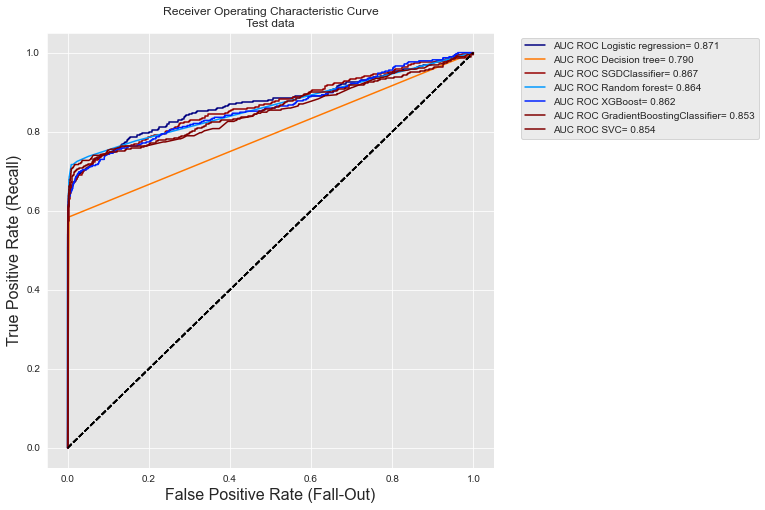

In [37]:
#ROC Curve

roc_curve, ax = plt.subplots(1, 1, figsize=(8,8))

cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree':cmap(200), 'SGDClassifier':cmap(250),
        'Random forest':cmap(70), 'XGBoost':cmap(40), 'GradientBoostingClassifier':cmap(1000),'SVC':cmap(500)}


    
for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    FPR_list, TPR_list, threshold = metrics.roc_curve(test_df[output_feature], model_and_predictions['predictions_test'])
    ROC_AUC = metrics.auc(FPR_list, TPR_list)

    ax.plot(FPR_list, TPR_list, 'b', color=colors[classifier_name], label = 'AUC ROC {0}= {1:0.3f}'.format(classifier_name,ROC_AUC))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.title('Receiver Operating Characteristic Curve\nTest data')
    plt.grid(True)

In [38]:
df_performances.sort_values(['AUC ROC'],ascending=False)

,AUC ROC,Average precision,Precision,Recall,F1score
Logistic regression,0.870531,0.605703,0.904523,0.467532,0.616438
SGDClassifier,0.867091,0.578979,0.909574,0.444156,0.596859
Random forest,0.864288,0.663395,0.965347,0.506494,0.664395
XGBoost,0.861821,0.638873,0.945455,0.540260,0.687603
SVC,0.854442,0.637534,0.967213,0.459740,0.623239
GradientBoostingClassifier,0.853136,0.541597,0.840000,0.545455,0.661417
Decision tree,0.790420,0.307129,0.520833,0.584416,0.550796


The curves show that decision trees have the lowest performances, while random forest, logistic regression, and boosting have similar performances.

ROC curves are relevant to get a sense of a classifier performance over the whole range of possible FPR. Their interest for fraud detection is however limited since an important goal of fraud detection is to keep the FPR very low. 

To get a sense of how low the FPR should be kept, let us recall that false positives are genuine transactions that are predicted as fraudulent. In an operational fraud system, these transactions will need to be manually handled by investigators. Due to the limited number of investigators, there is only a limited amount of transactions that can be checked. 

Let us consider more concretely how this constraint translates in terms of FPR. 



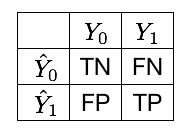

#### Confusion matrix 

Once a threshold $t$ is set, the outcome of a binary classification problem is usually represented as a *confusion matrix*. Denoting by $Y_1$ the set of positive instances (frauds), $Y_0$ the set of negative instances (genuine), $\hat{Y}_1$ the set of instances predicted as positive and $\hat{Y}_0$ the ones predicted as negative, the confusion matrix is represented as follows.
The four possible outcomes are

* TP: True positives. These are the instances of class 1 (fraudulent transactions), that the classifier correctly predicts as fraudulent.
* TN: True negatives. These are the instances of class 0 (genuine transactions), that the classifier correctly predicts as genuine.
* FP: False positives. These are the instances of class 0 (genuine transactions), that the classifier incorrectly predicts as fraudulent.
* FN: False negatives. These are the instances of class 1 (fraudulent transactions), that the classifier incorrectly predicts as genuine.

𝑇𝑃𝑅=𝑅𝑒𝑐𝑎𝑙𝑙=𝑇𝑃/𝑇𝑃+𝐹𝑁

𝐹𝑃𝑅=𝐹𝑃/𝑇𝑁+𝐹𝑃=1−𝑇𝑁𝑅

𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛=𝑇𝑃/𝑇𝑃+𝐹𝑃


In [39]:
test_df[test_df.TX_FRAUD==0].shape

(57879, 22)

In [40]:
test_df[test_df.TX_FRAUD==1].shape

(385, 22)

Assuming that 100 transactions can be checked every day, a total of 700 transactions could be checked after 7 days, that is, around 1% of the transactions. Therefore, any FPR higher than 0.01 will raise more alerts that can be handled by investigators.

Real-world fraud detection systems typically handle hundreds of thousands to millions of on a daily basis. The proportion of transactions that can be manually checked is in fact closer to 0.1% than 1%. That is, any FPR higher than 0.001 is already too high. 

As a result, due to the imbalanced nature of the problem, 99.9% of what is represented on the ROC curve has little relevance from the perspective of an operational fraud detection system where fraudulent transactions must be checked by a limited team of investigators. 

As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise

In [ ]:
#pr curve

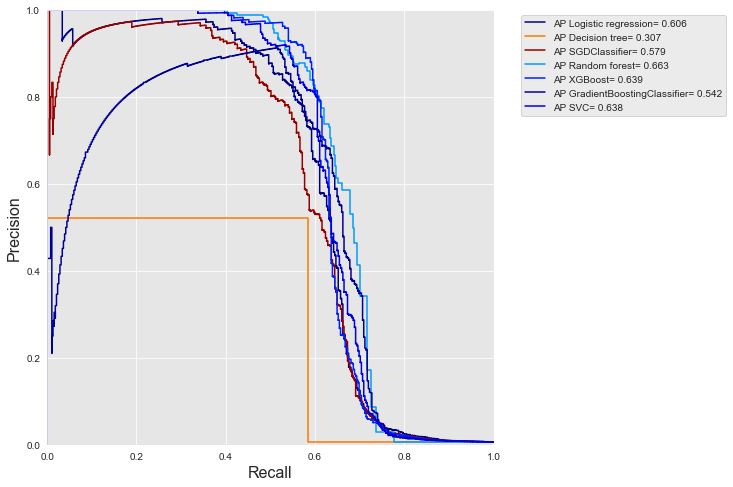

In [43]:
pr_curve, ax = plt.subplots(1, 1, figsize=(8,8))
cmap = plt.get_cmap('jet')
colors={'Logistic regression':cmap(0), 'Decision tree':cmap(200), 'SGDClassifier':cmap(250),
        'Random forest':cmap(70), 'XGBoost':cmap(40), 'GradientBoostingClassifier':cmap(5),'SVC':cmap(23)}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions=fitted_models_and_predictions_dictionary[classifier_name]

    precision, recall, threshold = metrics.precision_recall_curve(test_df[output_feature], model_and_predictions['predictions_test'])
    precision=precision[::-1]
    recall=recall[::-1]
    
    AP = metrics.average_precision_score(test_df[output_feature], model_and_predictions['predictions_test'])
    
    ax.step(recall, precision, 'b', color=colors[classifier_name], label = 'AP {0}= {1:0.3f}'.format(classifier_name,AP))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    


In [44]:
df_performances.sort_values(['Average precision'],ascending=False)

,AUC ROC,Average precision,Precision,Recall,F1score
Random forest,0.864288,0.663395,0.965347,0.506494,0.664395
XGBoost,0.861821,0.638873,0.945455,0.540260,0.687603
SVC,0.854442,0.637534,0.967213,0.459740,0.623239
Logistic regression,0.870531,0.605703,0.904523,0.467532,0.616438
SGDClassifier,0.867091,0.578979,0.909574,0.444156,0.596859
GradientBoostingClassifier,0.853136,0.541597,0.840000,0.545455,0.661417
Decision tree,0.790420,0.307129,0.520833,0.584416,0.550796


As pointed out above at the end of the section on ROC curves, the TPR for low FPR values is actually what matters in a fraud detection problem: The number of cards that can be manually checked by fraud investigators is in practice very limited. This also gives a different ordering of performances for the classifiers. For example, with ROC curves, decision trees with unlimited depth have a better AUC than a decision tree of depth two (0.788 versus 0.763, respectively). The performances are reversed when computed in terms of Average Precision (0.309 versus 0.496).

While PR curves are useful to highlight the performances of fraud detection systems for low FPR values,

. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise

AP 

summarizes a precision-recall curve as the weighted mean of precisions
achieved at each threshold, with the increase in recall from the previous
threshold used as the weight:

.. math::
    \text{AP} = \sum_n (R_n - R_{n-1}) P_n

where :math:`P_n` and :math:`R_n` are the precision and recall at the nth
threshold [1]_. This implementation is not interpolated and is different
from computing the area under the precision-recall curve with the
trapezoidal rule, which uses linear interpolation and can be too
optimistic.


https://towardsdatascience.com/demystifying-roc-and-precision-recall-curves-d30f3fad2cbf

# validation

The standard approach for assessing the generalization ability of a prediction model is a process known as *validation*. Validation consists in splitting the historical data into two sets. The first is used for training. The second, called *validation set*, is used to assess (validate) the generalization ability of the model

In credit card fraud detection, the purpose of a prediction model is more specifically to provide accurate predictions for transactions that will occur *in the future*. Due to the sequential nature of transaction data, special care must be taken when splitting the data into training and validation sets. In particular, the transactions of the validation set should occur *after* the transactions of the training set.  

(Prequential_validation)=
## Prequential validation

The repeated hold-out validation relies on random subsets of the same training data to build prediction models. A limitation of this approach is that it reduces the expected performances of the models, as only subsets of data are used for training. 

An alternative validation procedure consists in using training sets of similar sizes, taken from older historical data. The scheme is called *prequential validation*, and is illustrated in Fig. 5. Each fold shifts the training and validation sets by one block in the past. 
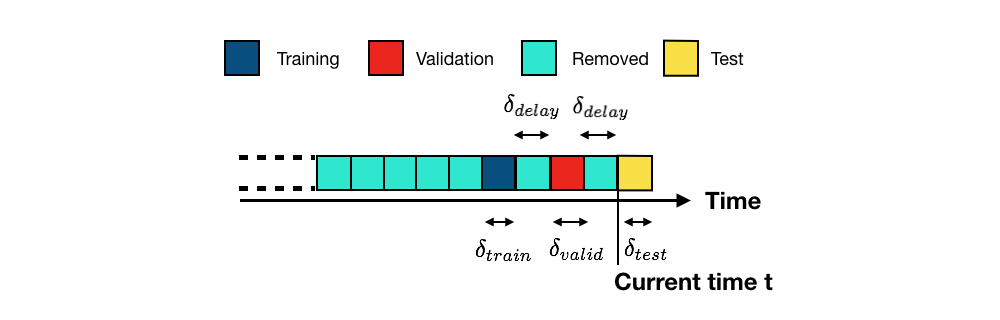

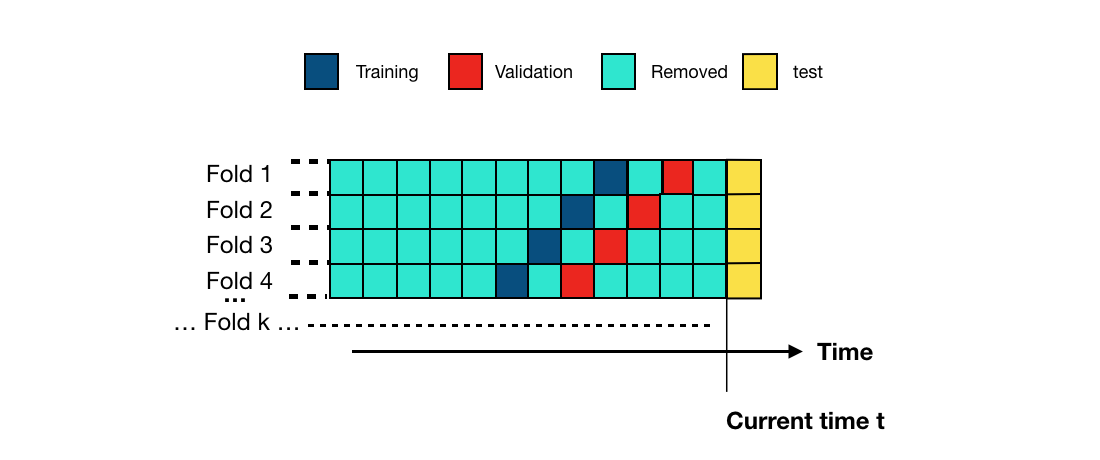
<div align="center">Fig. 5. Prequential validation: Each fold shifts the training and validation sets by one block in the past. The validation set has the same length as the test.</div>

The implementation is similar than the repeated hold-out validation. The only difference is that, for each fold, the starting dates for the training and validation sets are shifted by one block. The implementation is provided below, with the function `prequential_validation`. 


### Prequential splitting

Scikit-learn provides seven different strategies for splitting data for validation: `KFold`, `GroupKFold`, `ShuffleSplit`, `StratifiedKFold`, `GroupShuffleSplit`, `StratifiedShuffleSplit`, and `TimeSeriesSplit`. A visualization of these splitting strategies is provided [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html). None of these allows the prequential splitting of data illustrated in Fig. 5.

Let us define a `prequentialSplit` function, that returns the indices of the training and test sets for each of the folds of a prequential split. 


In [14]:
def prequentialSplit(transactions_df,
                     start_date_training, 
                     n_folds=4, 
                     delta_train=7,
                     delta_delay=7,
                     delta_assessment=7):
    
    prequential_split_indices=[]
        
    # For each fold
    for fold in range(n_folds):
        
        # Shift back start date for training by the fold index times the assessment period (delta_assessment)
        # (See Fig. 5)
        start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
        
        # Get the training and test (assessment) sets
        (train_df, test_df)=get_train_test_set(transactions_df,
                                               start_date_training=start_date_training_fold,
                                               delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
        # Get the indices from the two sets, and add them to the list of prequential splits
        indices_train=list(train_df.index)
        indices_test=list(test_df.index)
        
        prequential_split_indices.append((indices_train,indices_test))
    
    return prequential_split_indices

# grid searcxh 
we will do grid search with crossvalidation using prequentialSplit indices of train and validatin dataset

In [15]:
def prequential_grid_search(transactions_df, 
                            classifier, 
                            input_features, output_feature, 
                            parameters, scoring, 
                            start_date_training, 
                            n_folds=4,
                            expe_type='Test',
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):
    
    estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
    pipe = sklearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices=prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)
    
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, refit=False, n_jobs=n_jobs)
    
    X=transactions_df[input_features]
    y=transactions_df[output_feature]

    grid_search.fit(X, y)
    
    
    performances_df=pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters']=grid_search.cv_results_['params']
    performances_df['Execution time']=grid_search.cv_results_['mean_fit_time']
    
    

    return performances_df

        

In [7]:

# will require up to three months of data

# Load data from the 2018-06-11 to the 2018-09-14

 
BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

DIR_INPUT='simulated-data-transformed1/' 
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("Load  files")
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


Wall time: 12 s
Load  files
919767 transactions loaded, containing 8195 fraudulent transactions


In [8]:
# Number of folds for the prequential validation
n_folds = 4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))\

print("start_date_training--------------->",start_date_training)
print("-------------------------------------------------------")
print("start_date_training_for_valid----->",start_date_training_for_valid)



start_date_training---------------> 2018-07-25 00:00:00
-------------------------------------------------------
start_date_training_for_valid-----> 2018-07-11 00:00:00


For the sake of conciseness, let us define a `model_selection_wrapper` function, that will perform prequential validation for both the validation and the test sets. 

In [19]:
def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
   
   


    return performances_df_validation


In [20]:
# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)


performance_metrics_list_grid = ['roc_auc', 'average_precision']
performance_metrics_list = ['AUC ROC', 'Average precision']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           }


#### model selction -DecisionTreeClassifier

Prequential validation can now be performed with the few following lines of code, by

* defining which classifier to use
* defining which parameters to test
* fitting the models and assessing the performances

The implementation using decision trees as predictions models, for maximum depth in $[2,3,4,5,6,7,8,9,10,20,50]$, is obtained with:

In [23]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,5,10,20,50,100,500], 'clf__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        n_folds=4,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt=performances_df


In [24]:
performances_df_dt

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.790786,0.012035,0.549767,0.022134,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.858202,2
1,0.802717,0.017607,0.573414,0.027186,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.830194,3
2,0.804218,0.016505,0.546094,0.042197,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.917963,5
3,0.786784,0.031165,0.493543,0.048307,"{'clf__max_depth': 10, 'clf__random_state': 0}",1.388177,10
4,0.780408,0.022168,0.450980,0.031413,"{'clf__max_depth': 20, 'clf__random_state': 0}",2.283632,20
5,0.822564,0.013407,0.341818,0.026227,"{'clf__max_depth': 50, 'clf__random_state': 0}",2.637104,50
6,0.822564,0.013407,0.341818,0.026227,"{'clf__max_depth': 100, 'clf__random_state': 0}",2.743090,100
7,0.822564,0.013407,0.341818,0.026227,"{'clf__max_depth': 500, 'clf__random_state': 0}",2.671089,500


In [25]:
def get_summary_performances(performances_df, parameter_column_name="Parameters summary"):

    # Three performance metrics
    metrics = ['AUC ROC','Average precision']
    performances_results=pd.DataFrame(columns=metrics)
    
    # Reset indices in case a subset of a performane DataFrame is provided as input
    performances_df.reset_index(drop=True,inplace=True)

    # Lists of parameters/performances that will be retrieved for the best estimated parameters
    best_estimated_parameters = []
    validation_performance = []
    
    
    # For each performance metric, get the validation and test performance for the best estimated parameter
    for metric in metrics:
    
        # Find the index which provides the best validation performance
        index_best_validation_performance = performances_df.index[np.argmax(performances_df[metric+' Validation'].values)]
    
        # Retrieve the corresponding parameters
        best_estimated_parameters.append(performances_df[parameter_column_name].iloc[index_best_validation_performance])
        
        # Add validation performance to the validation_performance list (mean+/-std)
        validation_performance.append(
                str(round(performances_df[metric+' Validation'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Validation'+' Std'].iloc[index_best_validation_performance],2))
        )
        
       
    # Add results to the performances_results DataFrame
    performances_results.loc["Best estimated parameters"]=best_estimated_parameters
    performances_results.loc["Validation performance"]=validation_performance
   

    
    return performances_results


In [41]:
summary_performances_dt1=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt1

,AUC ROC,Average precision
Best estimated parameters,50,3
Validation performance,0.823+/-0.01,0.573+/-0.03


The first row provides the parameters that maximize the performances on the validation set (best estimated parameters $k^*$). The second and third rows provide the corresponding performances on the validation and test sets, respectively. The fourth row provides the actual optimal parameters on the test set (the parameters that maximize the performances on the test set). The fifth row provides the corresponding performances on the test set.

Two important observations can be made from this summary table. First, the optimal parameter depends on the performance metrics: It is a maximum depth of 4 for AUC ROC and AP, while it is a maximum depth of 5 for the CP@100. Second, the best parameters for the validation may not be the optimal parameter for the test set. This is the case for the AUC ROC (maximum depth of 50 for the validation set versus 4 for the test set), and the AP (maximum depth of 3 for the validation set versus 4 for the test set). 

Similar to the section [Validation Strategies](Validation_Strategies), let us plot the performances as a function of the decision tree depth. The vertical dashed line is the tree depth for which the performance is maximized on the validation data.



## Cost-sensitive approach

Let us now explore whether changing the class weights can improve the classification performances on the simulated dataset of transaction data.

In [37]:
transactions_df.shape,transactions_df.TX_FRAUD.value_counts()

((919767, 22),
 0    911572
 1      8195
 Name: TX_FRAUD, dtype: int64)

In [36]:
#imbalanced ratio----

X1 = 8195    #samples belonging to the minority class(class1-- fraud transactin)
X0 = 911572  #samples belonging to the majority class(class0--- valid transaction)

IR = X1/X0
print('imbalanced ratio', np.round(IR,2))

imbalanced ratio 0.01


The transaction dataset contains around 0.7% of fraudulent transactions. The imbalance ratio is therefore around 1/100. In order to assess the impact of the class weight parameter on the classification performance, we vary the class weight in the range 0.01 to 1, with the following set of possible values:  [0.01,0.05,0.1,0.5,1] .

In [48]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,5,10,20,50], 'clf__random_state':[0],
              'clf__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1]]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_dt = time.time()-start_time


# Select parameter of interest (class_weight)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [str(parameters_dict[i]['clf__class_weight'][0])+'/'+
                                   str(parameters_dict[i]['clf__max_depth']) for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt = performances_df

In [49]:
performances_df_dt

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.818241,0.013968,0.228136,0.014552,"{'clf__class_weight': {0: 0.01}, 'clf__max_dep...",0.929699,0.01/2
1,0.823738,0.016626,0.356831,0.015259,"{'clf__class_weight': {0: 0.01}, 'clf__max_dep...",0.860454,0.01/3
2,0.837454,0.014356,0.532924,0.025252,"{'clf__class_weight': {0: 0.01}, 'clf__max_dep...",1.062687,0.01/5
3,0.791749,0.028448,0.542051,0.027166,"{'clf__class_weight': {0: 0.01}, 'clf__max_dep...",1.344175,0.01/10
4,0.805676,0.013011,0.403239,0.031869,"{'clf__class_weight': {0: 0.01}, 'clf__max_dep...",1.642917,0.01/20
5,0.802096,0.012703,0.337886,0.030190,"{'clf__class_weight': {0: 0.01}, 'clf__max_dep...",2.122878,0.01/50
6,0.800877,0.016538,0.367372,0.046965,"{'clf__class_weight': {0: 0.05}, 'clf__max_dep...",0.868942,0.05/2
7,0.805697,0.014803,0.502169,0.021432,"{'clf__class_weight': {0: 0.05}, 'clf__max_dep...",0.920695,0.05/3
8,0.808213,0.022140,0.565880,0.027737,"{'clf__class_weight': {0: 0.05}, 'clf__max_dep...",0.957936,0.05/5
9,0.777337,0.030377,0.530270,0.025771,"{'clf__class_weight': {0: 0.05}, 'clf__max_dep...",1.367678,0.05/10


In [50]:
summary_performances_dt2 = get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt2

,AUC ROC,Average precision
Best estimated parameters,0.01/5,1/3
Validation performance,0.837+/-0.01,0.573+/-0.03


In [44]:
summary_performances_dt1

,AUC ROC,Average precision
Best estimated parameters,50,3
Validation performance,0.823+/-0.01,0.573+/-0.03


## Resampling strategies

### Prequential validation with resampling

The addition of resampling to the prequential validation simply consists in extending the pipeline defined in [Chapter 5, Validation Strategies](Sklearn_Validation_Pipeline) with the sampler objects. We add this step at the beginning of the `prequential_grid_search` function and rename it as `prequential_grid_search_with_sampler`. Note that the pipeline is created with the `Pipeline` object from the `imblearn` module so that samplers are properly processed.

In [61]:
def prequential_grid_search_with_sampler(transactions_df, 
                                         classifier, sampler_list,
                                         input_features, output_feature, 
                                         parameters, scoring, 
                                         start_date_training, 
                                         n_folds=4,
                                         expe_type='Test',
                                         delta_train=7, 
                                         delta_delay=7, 
                                         delta_assessment=7,
                                         performance_metrics_list_grid=['roc_auc'],
                                         performance_metrics_list=['AUC ROC'],
                                         n_jobs=-1):
    
    estimators = sampler_list.copy()
    estimators.extend([('clf', classifier)])
    
    pipe = imblearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices = prequentialSplit(transactions_df,
                                                 start_date_training=start_date_training, 
                                                 n_folds=n_folds, 
                                                 delta_train=delta_train, 
                                                 delta_delay=delta_delay, 
                                                 delta_assessment=delta_assessment)
    
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, refit=False, n_jobs=n_jobs)
    
    X = transactions_df[input_features]
    y = transactions_df[output_feature]

    grid_search.fit(X, y)
    
    performances_df = pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters'] = grid_search.cv_results_['params']
    performances_df['Execution time'] = grid_search.cv_results_['mean_fit_time']
    
    return performances_df

The `model_selection_wrapper` function is also modified into a `model_selection_wrapper_with_sampler` function, which calls the `prequential_grid_search_with_sampler` function for prequential grid search. 

In [62]:
def model_selection_wrapper_with_sampler(transactions_df, 
                                         classifier, 
                                         sampler_list,
                                         input_features, output_feature,
                                         parameters, 
                                         scoring, 
                                         start_date_training_for_valid,
                                         n_folds=4,
                                         delta_train=7, 
                                         delta_delay=7, 
                                         delta_assessment=7,
                                         performance_metrics_list_grid=['roc_auc'],
                                         performance_metrics_list=['AUC ROC'],
                                         n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation = prequential_grid_search_with_sampler(transactions_df, classifier, sampler_list,
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
   
    return performances_df_validation

(Resampling_Strategies_Transaction_Data_Oversampling)=
### Oversampling

Let us illustrate its use with SMOTE oversampling. We create a `SMOTE` object and store it in a `sampler_list` list. The list is passed as an argument to the `model_selection_wrapper_with_sampler` function. Additionally, the `sampling_strategy` parameter to the `SMOTE` object (imbalance ratio) is parametrized to take values in the set $[0.01, 0.05, 0.1, 0.5, 1]$ for the model selection procedure.  


In [63]:
import imblearn

In [64]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Define sampling strategy
sampler_list = [('sampler', imblearn.over_sampling.SMOTE(random_state=0))]

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,5,10,20,50], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_SMOTE = time.time()-start_time


In [65]:
# Select parameter of interest (sampling_strategy)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['sampler__sampling_strategy'])+'/'+
                                   str(parameters_dict[i]['clf__max_depth'])for i in range(len(parameters_dict))]

# Rename to performances_df_SMOTE for model performance comparison at the end of this notebook
performances_df_SMOTE = performances_df

In [66]:
performances_df_SMOTE

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.791428,0.011217,0.547260,0.025303,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",0.860466,0.01/2
1,0.799932,0.010099,0.468619,0.047102,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",0.846205,0.05/2
2,0.806590,0.011040,0.402592,0.047880,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",0.929719,0.1/2
3,0.813275,0.011021,0.259809,0.042126,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",1.144434,0.5/2
4,0.816995,0.011090,0.231997,0.022778,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",1.258693,1/2
5,0.801790,0.011893,0.569776,0.021933,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",1.018190,0.01/3
6,0.804036,0.016012,0.530589,0.032766,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",1.047433,0.05/3
7,0.810204,0.011046,0.514196,0.033393,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",0.880195,0.1/3
8,0.823555,0.017130,0.398360,0.029146,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",1.193950,0.5/3
9,0.825337,0.015598,0.358702,0.055696,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",1.517655,1/3


In [67]:
summary_performances_SMOTE = get_summary_performances(performances_df_SMOTE, parameter_column_name="Parameters summary")
summary_performances_SMOTE

,AUC ROC,Average precision
Best estimated parameters,1/5,0.01/3
Validation performance,0.857+/-0.01,0.57+/-0.02


(Resampling_Strategies_Transaction_Data_RUS)=
### Undersampling

Let us follow the same methodology using random undersampling. The `RandomUnderSampler` object is used, and models are assessed for imbalance ratios taking values in the set $[0.01, 0.05, 0.1, 0.5, 1]$.

In [69]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Define sampling strategy
sampler_list = [('sampler', imblearn.under_sampling.RandomUnderSampler())]

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,5,10], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01,0.05,0.1,0.5,1], 'sampler__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_RUS = time.time()-start_time

# Select parameter of interest (sampling_strategy)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['sampler__sampling_strategy'])+'/'+
                                   str(parameters_dict[i]['clf__max_depth'])for i in range(len(parameters_dict))]

# Rename to performances_df_RUS for model performance comparison at the end of this notebook
performances_df_RUS = performances_df


In [70]:
performances_df_RUS

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.790783,0.012030,0.548228,0.019737,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",0.816706,0.01/2
1,0.796775,0.012378,0.493458,0.046282,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",0.557230,0.05/2
2,0.802272,0.010971,0.388614,0.050922,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",0.521472,0.1/2
3,0.812935,0.008189,0.250657,0.045872,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",0.651464,0.5/2
4,0.820651,0.013652,0.207362,0.037871,"{'clf__max_depth': 2, 'clf__random_state': 0, ...",0.564480,1/2
5,0.802594,0.017586,0.568275,0.020332,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",0.788967,0.01/3
6,0.801834,0.016934,0.539439,0.035515,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",0.558208,0.05/3
7,0.806248,0.015340,0.500011,0.057022,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",0.605954,0.1/3
8,0.820857,0.013344,0.297111,0.055994,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",0.674492,0.5/3
9,0.834337,0.013108,0.234031,0.068456,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",0.554970,1/3


In [71]:
summary_performances_RUS=get_summary_performances(performances_df_RUS, parameter_column_name="Parameters summary")
summary_performances_RUS

,AUC ROC,Average precision
Best estimated parameters,1/5,0.01/3
Validation performance,0.845+/-0.01,0.568+/-0.02



### Combining(hybrid resampling)

We finally illustrate the combination of oversampling and undersampling with SMOTE and random undersampling. A `SMOTE` and `RandomUnderSampler` objects are instantiated and stored in the `sampler_list` list. We parametrize the `SMOTE` sampler with a target imbalance ratio of $0.1$, and the `RandomUnderSampler` to take values in the set $[0.1, 0.5, 1]$.

In [80]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Define sampling strategy
sampler_list = [('sampler1', imblearn.over_sampling.SMOTE()),
                ('sampler2', imblearn.under_sampling.RandomUnderSampler())
               ]

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[5,3], 'clf__random_state':[0],
              'sampler1__sampling_strategy':[0.01], 
              'sampler2__sampling_strategy':[0.01, 1], 
              'sampler1__random_state':[0], 'sampler2__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                    
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_combined = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['sampler2__sampling_strategy'])+'/'+
                                   str(parameters_dict[i]['clf__max_depth']) for i in range(len(parameters_dict))]

# Rename to performances_df_combined for model performance comparison at the end of this notebook
performances_df_combined = performances_df


In [81]:
performances_df_combined

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.803468,0.014269,0.554155,0.032957,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",1.264944,0.01/5
1,0.848002,0.012531,0.142712,0.016700,"{'clf__max_depth': 5, 'clf__random_state': 0, ...",0.605967,1/5
2,0.801790,0.011893,0.569776,0.021933,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",0.911204,0.01/3
3,0.833450,0.017874,0.287233,0.036896,"{'clf__max_depth': 3, 'clf__random_state': 0, ...",0.596966,1/3


In [82]:
summary_performances_combined = get_summary_performances(performances_df=performances_df_combined, 
                                                         parameter_column_name="Parameters summary")
summary_performances_combined

,AUC ROC,Average precision
Best estimated parameters,1/5,0.01/3
Validation performance,0.848+/-0.01,0.57+/-0.02


In [86]:
summary_test_performances = pd.concat([summary_performances_dt1.iloc[1,:],
                                       summary_performances_dt2.iloc[1,:],
                                       summary_performances_SMOTE.iloc[1,:],
                                       summary_performances_RUS.iloc[1,:],
                                       summary_performances_combined.iloc[1,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline','Classwtmanupulation', 'SMOTE', 'RUS', 'Combined']
summary_test_performances

,Baseline,Classwtmanupulation,SMOTE,RUS,Combined
AUC ROC,0.823+/-0.01,0.837+/-0.01,0.857+/-0.01,0.845+/-0.01,0.848+/-0.01
Average precision,0.573+/-0.03,0.573+/-0.03,0.57+/-0.02,0.568+/-0.02,0.57+/-0.02


Compared to the baseline classifier, all resampling techniques managed to improve the performances in terms of AUC ROC. All of them however led to a decrease in Average Precision. Slight improvements in terms of CP@100 could be achieved with SMOTE and the combined approach, but not with undersampling.

## Summary

The experiments carried out in this section illustrated that the benefits of resampling techniques depend on the performance metric that is used. While resampling can generally be beneficial to AUC ROC, we observed that they led in almost all cases to a decrease of performances in terms of Average Precision. It is worth noting that the results are coherent with those obtained using cost-sensitive techniques in [the previous section](Cost_Sensitive_Learning). 

In [206]:
SGDClassifier(random_state=42)

SGDClassifier(random_state=42)

(Model_Selection_Logistic_Regression)=
### Logistic regression

The main hyperparameter of logistic regression is the [regularization parameter C](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). The [default value for this parameter is 1](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression). Let us try fitting models with lower and higher values, for example in the set [0.1,1,10,100].   

In [114]:
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[0.1,1,10,100,500], 'clf__random_state':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_lr = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__C'] for i in range(len(parameters_dict))]

# Rename to performances_df_lr for model performance comparison at the end of this notebook
performances_df_lr=performances_df

In [88]:
performances_df_lr

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.865052,0.009591,0.608330,0.022740,"{'clf__C': 0.1, 'clf__random_state': 0}",1.144438,0.1
1,0.866861,0.008988,0.612264,0.023474,"{'clf__C': 1, 'clf__random_state': 0}",1.213436,1.0
2,0.867050,0.008918,0.612526,0.023715,"{'clf__C': 10, 'clf__random_state': 0}",1.104441,10.0
3,0.867071,0.008912,0.612537,0.023712,"{'clf__C': 100, 'clf__random_state': 0}",1.111190,100.0
4,0.867072,0.008911,0.612545,0.023713,"{'clf__C': 500, 'clf__random_state': 0}",1.045194,500.0


The `get_summary_performances` function gives the summary of the best parameters and corresponding performances.

In [115]:
summary_performances_lr1=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr1

,AUC ROC,Average precision
Best estimated parameters,500.0,500.0
Validation performance,0.867+/-0.01,0.613+/-0.02


Let us plot the performances as a function of the regularization value, together with the value that provides the best estimated performances.  

Performances tend to be a bit lower for a low $C$ value (0.1). $C$ values equal or higher than one provide similar performances. The default parameter $C=1$ seems therefore to be a sensible value for the logistic regression model. 

In [90]:
# Define classifier
classifier = sklearn.linear_model.LogisticRegression()

# Set of parameters for which to assess model performances
parameters = {'clf__C':[0.1,1,10], 'clf__random_state':[0],
              'clf__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1]]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_lr = time.time()-start_time






In [91]:
# Select parameter of interest (class_weight)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__class_weight'][0])+'/'+str(parameters_dict[i]['clf__C'])for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_lr=performances_df


In [92]:
performances_df_lr

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.866875,0.009632,0.484012,0.041438,"{'clf__C': 0.1, 'clf__class_weight': {0: 0.01}...",0.829213,0.01/0.1
1,0.867357,0.008598,0.540353,0.030419,"{'clf__C': 0.1, 'clf__class_weight': {0: 0.05}...",0.846455,0.05/0.1
2,0.867166,0.008698,0.571812,0.017336,"{'clf__C': 0.1, 'clf__class_weight': {0: 0.1},...",1.140188,0.1/0.1
3,0.865831,0.009443,0.605000,0.021464,"{'clf__C': 0.1, 'clf__class_weight': {0: 0.5},...",1.206436,0.5/0.1
4,0.865052,0.009591,0.608330,0.022740,"{'clf__C': 0.1, 'clf__class_weight': {0: 1}, '...",1.027946,1/0.1
5,0.871069,0.009955,0.497808,0.039734,"{'clf__C': 1, 'clf__class_weight': {0: 0.01}, ...",0.939450,0.01/1
6,0.870584,0.008772,0.550617,0.029466,"{'clf__C': 1, 'clf__class_weight': {0: 0.05}, ...",1.070193,0.05/1
7,0.869906,0.008720,0.579392,0.019886,"{'clf__C': 1, 'clf__class_weight': {0: 0.1}, '...",0.980699,0.1/1
8,0.867853,0.008948,0.608950,0.023132,"{'clf__C': 1, 'clf__class_weight': {0: 0.5}, '...",1.061943,0.5/1
9,0.866861,0.008988,0.612264,0.023474,"{'clf__C': 1, 'clf__class_weight': {0: 1}, 'cl...",1.105691,1/1


In [93]:
summary_performances_lr = get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision
Best estimated parameters,0.01/10,1/10
Validation performance,0.872+/-0.01,0.613+/-0.02


### Prequential validation with resampling

In [155]:
#0versampling

In [95]:
classifier = sklearn.linear_model.LogisticRegression()


# Define sampling strategy
sampler_list = [('sampler', imblearn.over_sampling.SMOTE(random_state=0))]

# Set of parameters for which to assess model performances
parameters = {'clf__C':[0.1,1,10], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_SMOTE = time.time()-start_time


In [98]:
# Select parameter of interest (sampling_strategy)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['sampler__sampling_strategy'])+'/'+str(parameters_dict[i]['clf__C']) for i in range(len(parameters_dict))]

# Rename to performances_df_SMOTE for model performance comparison at the end of this notebook
performances_df_SMOTE = performances_df

In [99]:
summary_performances_SMOTE = get_summary_performances(performances_df_SMOTE, parameter_column_name="Parameters summary")
summary_performances_SMOTE

,AUC ROC,Average precision
Best estimated parameters,0.01/1,0.01/1
Validation performance,0.872+/-0.01,0.487+/-0.02


(Resampling_Strategies_Transaction_Data_RUS)=
### Undersampling

Let us follow the same methodology using random undersampling. The `RandomUnderSampler` object is used, and models are assessed for imbalance ratios taking values in the set $[0.01, 0.05, 0.1, 0.5, 1]$.

In [104]:
# Define classifier
classifier = sklearn.linear_model.LogisticRegression()

# Define sampling strategy
sampler_list = [('sampler', imblearn.under_sampling.RandomUnderSampler())]

# Set of parameters for which to assess model performances
parameters = {'clf__C':[10,100], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_RUS = time.time()-start_time

# Select parameter of interest (sampling_strategy)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['sampler__sampling_strategy'])+'/'+
                                   str(parameters_dict[i]['clf__C'])for i in range(len(parameters_dict))]

# Rename to performances_df_RUS for model performance comparison at the end of this notebook
performances_df_RUS = performances_df


In [105]:
performances_df_RUS

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.872528,0.010717,0.483787,0.019397,"{'clf__C': 10, 'clf__random_state': 0, 'sample...",1.685402,0.01/10
1,0.875532,0.011496,0.487232,0.019209,"{'clf__C': 10, 'clf__random_state': 0, 'sample...",0.714462,0.05/10
2,0.876031,0.010802,0.479266,0.017683,"{'clf__C': 10, 'clf__random_state': 0, 'sample...",0.785957,0.1/10
3,0.876243,0.010070,0.454447,0.024767,"{'clf__C': 10, 'clf__random_state': 0, 'sample...",0.911950,0.5/10
4,0.874625,0.011452,0.457869,0.025189,"{'clf__C': 10, 'clf__random_state': 0, 'sample...",0.787460,1/10
5,0.872684,0.009790,0.489536,0.018138,"{'clf__C': 100, 'clf__random_state': 0, 'sampl...",1.825401,0.01/100
6,0.875544,0.010982,0.485329,0.019573,"{'clf__C': 100, 'clf__random_state': 0, 'sampl...",0.788968,0.05/100
7,0.876035,0.009817,0.479440,0.017588,"{'clf__C': 100, 'clf__random_state': 0, 'sampl...",0.714711,0.1/100
8,0.876488,0.010144,0.452671,0.029521,"{'clf__C': 100, 'clf__random_state': 0, 'sampl...",0.772708,0.5/100
9,0.874907,0.011222,0.455924,0.028691,"{'clf__C': 100, 'clf__random_state': 0, 'sampl...",0.604230,1/100


In [106]:
summary_performances_RUS=get_summary_performances(performances_df_RUS, parameter_column_name="Parameters summary")
summary_performances_RUS

,AUC ROC,Average precision
Best estimated parameters,0.5/100,0.01/100
Validation performance,0.876+/-0.01,0.49+/-0.02


(Resampling_Strategies_Transaction_Data_Combining)=
### Combining

We finally illustrate the combination of oversampling and undersampling with SMOTE and random undersampling. A `SMOTE` and `RandomUnderSampler` objects are instantiated and stored in the `sampler_list` list. We parametrize the `SMOTE` sampler with a target imbalance ratio of $0.1$, and the `RandomUnderSampler` to take values in the set $[0.1, 0.5, 1]$.

In [109]:
# Define classifier
classifier = sklearn.linear_model.LogisticRegression()

# Define sampling strategy
sampler_list = [('sampler1', imblearn.over_sampling.SMOTE()),
                ('sampler2', imblearn.under_sampling.RandomUnderSampler())
               ]

# Set of parameters for which to assess model performances
parameters = {'clf__C':[1,100], 'clf__random_state':[0],
              'sampler1__sampling_strategy':[0.01], 
              'sampler2__sampling_strategy':[0.01,0.5, 1], 
              'sampler1__random_state':[0], 'sampler2__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                    
                                                     n_folds =n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_combined = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler2__sampling_strategy'] for i in range(len(parameters_dict))]

# Rename to performances_df_combined for model performance comparison at the end of this notebook
performances_df_combined = performances_df


In [110]:
performances_df_combined

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.872082,0.010410,0.487104,0.019371,"{'clf__C': 1, 'clf__random_state': 0, 'sampler...",2.041142,0.01
1,0.875999,0.010225,0.470564,0.019239,"{'clf__C': 1, 'clf__random_state': 0, 'sampler...",0.657723,0.50
2,0.875795,0.010758,0.472217,0.019507,"{'clf__C': 1, 'clf__random_state': 0, 'sampler...",0.661222,1.00
3,0.872227,0.010676,0.487365,0.018355,"{'clf__C': 100, 'clf__random_state': 0, 'sampl...",1.997644,0.01
4,0.876905,0.010037,0.460274,0.021820,"{'clf__C': 100, 'clf__random_state': 0, 'sampl...",0.662457,0.50
5,0.875485,0.010512,0.449309,0.024599,"{'clf__C': 100, 'clf__random_state': 0, 'sampl...",0.663464,1.00


In [111]:
summary_performances_combined = get_summary_performances(performances_df=performances_df_combined, 
                                                         parameter_column_name="Parameters summary")
summary_performances_combined

,AUC ROC,Average precision
Best estimated parameters,0.5,0.01
Validation performance,0.877+/-0.01,0.487+/-0.02


In [117]:
summary_test_performances = pd.concat([summary_performances_lr1.iloc[1,:],
                                       summary_performances_lr.iloc[1,:],
                                       summary_performances_SMOTE.iloc[1,:],
                                       summary_performances_RUS.iloc[1,:],
                                       summary_performances_combined.iloc[1,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline','Classwt_manupulation', 'SMOTE', 'RUS', 'Combined']
summary_test_performances

,Baseline,Classwtmanupulation,SMOTE,RUS,Combined
AUC ROC,0.867+/-0.01,0.872+/-0.01,0.872+/-0.01,0.876+/-0.01,0.877+/-0.01
Average precision,0.613+/-0.02,0.613+/-0.02,0.487+/-0.02,0.49+/-0.02,0.487+/-0.02


# SGDClassifier

In [119]:
# Define classifier
classifier = SGDClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__alpha':[0.0001,0.001,.01,1], 'clf__random_state':[0]}
             

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_dt = time.time()-start_time




In [120]:
# Select parameter of interest (class_weight)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__alpha'] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_sd = performances_df

In [121]:
performances_df_sd

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.813926,0.041265,0.487919,0.075097,"{'clf__alpha': 0.0001, 'clf__random_state': 0}",0.975441,0.0001
1,0.846153,0.016470,0.550613,0.021715,"{'clf__alpha': 0.001, 'clf__random_state': 0}",0.952223,0.0010
2,0.838049,0.012125,0.460809,0.020988,"{'clf__alpha': 0.01, 'clf__random_state': 0}",0.840226,0.0100
3,0.835572,0.010328,0.342696,0.046427,"{'clf__alpha': 1, 'clf__random_state': 0}",0.829217,1.0000


In [122]:
summary_performances_sd1 = get_summary_performances(performances_df_sd, parameter_column_name="Parameters summary")
summary_performances_sd1

,AUC ROC,Average precision
Best estimated parameters,0.001,0.001
Validation performance,0.846+/-0.02,0.551+/-0.02


In [123]:
# Define classifier
classifier = SGDClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__alpha':[0.0001,0.001,.01,1], 'clf__random_state':[0],
              'clf__class_weight':[{0: w} for w in [0.01, 0.05, 0.1, 0.5, 1]]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

execution_time_dt = time.time()-start_time




In [124]:
# Select parameter of interest (class_weight)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [str(parameters_dict[i]['clf__class_weight'][0])+'/'+
                                   str(parameters_dict[i]['clf__alpha']) for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_sd = performances_df

In [125]:
performances_df_sd

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.870641,0.009094,0.466699,0.035069,"{'clf__alpha': 0.0001, 'clf__class_weight': {0...",1.116697,0.01/0.0001
1,0.871788,0.007213,0.529904,0.043832,"{'clf__alpha': 0.0001, 'clf__class_weight': {0...",0.969445,0.05/0.0001
2,0.872585,0.007332,0.529585,0.041896,"{'clf__alpha': 0.0001, 'clf__class_weight': {0...",0.935465,0.1/0.0001
3,0.867115,0.007140,0.547101,0.032987,"{'clf__alpha': 0.0001, 'clf__class_weight': {0...",0.897966,0.5/0.0001
4,0.813926,0.041265,0.487919,0.075097,"{'clf__alpha': 0.0001, 'clf__class_weight': {0...",0.863966,1/0.0001
5,0.865027,0.008243,0.447926,0.037739,"{'clf__alpha': 0.001, 'clf__class_weight': {0:...",0.832966,0.01/0.001
6,0.869214,0.008814,0.514188,0.025397,"{'clf__alpha': 0.001, 'clf__class_weight': {0:...",0.799221,0.05/0.001
7,0.870452,0.010794,0.533300,0.036264,"{'clf__alpha': 0.001, 'clf__class_weight': {0:...",0.901202,0.1/0.001
8,0.856218,0.015697,0.591499,0.018485,"{'clf__alpha': 0.001, 'clf__class_weight': {0:...",0.950698,0.5/0.001
9,0.846153,0.016470,0.550613,0.021715,"{'clf__alpha': 0.001, 'clf__class_weight': {0:...",0.986217,1/0.001


In [126]:
summary_performances_sd2 = get_summary_performances(performances_df_sd, parameter_column_name="Parameters summary")
summary_performances_sd2

,AUC ROC,Average precision
Best estimated parameters,0.1/0.0001,0.5/0.001
Validation performance,0.873+/-0.01,0.591+/-0.02


(Resampling_Strategies_Transaction_Data_Oversampling)=
### Oversampling

Let us illustrate its use with SMOTE oversampling. We create a `SMOTE` object and store it in a `sampler_list` list. The list is passed as an argument to the `model_selection_wrapper_with_sampler` function. Additionally, the `sampling_strategy` parameter to the `SMOTE` object (imbalance ratio) is parametrized to take values in the set $[0.01, 0.05, 0.1, 0.5, 1]$ for the model selection procedure.  


In [96]:
import imblearn

In [128]:
# Define classifier
classifier = SGDClassifier()

# Define sampling strategy
sampler_list = [('sampler', imblearn.over_sampling.SMOTE(random_state=0))]

# Set of parameters for which to assess model performances
parameters = {'clf__alpha':[0.001, .01], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     n_folds=4,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_SMOTE = time.time()-start_time


In [129]:
# Select parameter of interest (sampling_strategy)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['sampler__sampling_strategy'])+'/'+
                                   str(parameters_dict[i]['clf__alpha'])for i in range(len(parameters_dict))]

# Rename to performances_df_SMOTE for model performance comparison at the end of this notebook
performances_df_SMOTE = performances_df

In [130]:
performances_df_SMOTE

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.780971,0.036134,0.269706,0.044054,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",1.809165,0.01/0.001
1,0.836427,0.036097,0.397490,0.072929,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",2.678636,0.05/0.001
2,0.859147,0.010471,0.475042,0.025643,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",3.653318,0.1/0.001
3,0.860295,0.018536,0.432876,0.036762,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",5.990954,0.5/0.001
4,0.867704,0.011708,0.452084,0.006914,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",7.586121,1/0.001
5,0.691967,0.047984,0.199302,0.106083,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",1.411949,0.01/0.01
6,0.852620,0.006377,0.408434,0.035711,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",1.785918,0.05/0.01
7,0.855191,0.015401,0.432878,0.066944,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",2.131172,0.1/0.01
8,0.869395,0.008599,0.484414,0.030131,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",3.248340,0.5/0.01
9,0.869016,0.009367,0.472614,0.024701,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",3.032625,1/0.01


In [131]:
summary_performances_SMOTE = get_summary_performances(performances_df_SMOTE, parameter_column_name="Parameters summary")
summary_performances_SMOTE

,AUC ROC,Average precision
Best estimated parameters,0.5/0.01,0.5/0.01
Validation performance,0.869+/-0.01,0.484+/-0.03


(Resampling_Strategies_Transaction_Data_RUS)=
### Undersampling

Let us follow the same methodology using random undersampling. The `RandomUnderSampler` object is used, and models are assessed for imbalance ratios taking values in the set $[0.01, 0.05, 0.1, 0.5, 1]$.

In [133]:
# Define classifier
classifier = SGDClassifier()

# Define sampling strategy
sampler_list = [('sampler', imblearn.under_sampling.RandomUnderSampler())]

# Set of parameters for which to assess model performances
parameters = {'clf__alpha':[0.001, .01], 'clf__random_state':[0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     n_folds=4,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_RUS = time.time()-start_time

# Select parameter of interest (sampling_strategy)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['sampler__sampling_strategy'])+'/'+
                                   str(parameters_dict[i]['clf__alpha'])for i in range(len(parameters_dict))]

# Rename to performances_df_RUS for model performance comparison at the end of this notebook
performances_df_RUS = performances_df


In [134]:
performances_df_RUS

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.806355,0.016587,0.335717,0.025683,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",2.033403,0.01/0.001
1,0.798342,0.044527,0.354175,0.090334,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",0.795221,0.05/0.001
2,0.794450,0.078062,0.306403,0.127661,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",0.747221,0.1/0.001
3,0.776108,0.041046,0.271777,0.121933,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",0.628727,0.5/0.001
4,0.792855,0.058805,0.246319,0.038534,"{'clf__alpha': 0.001, 'clf__random_state': 0, ...",0.608990,1/0.001
5,0.699323,0.046071,0.246382,0.053032,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",1.288196,0.01/0.01
6,0.809742,0.023028,0.339278,0.055088,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",0.665508,0.05/0.01
7,0.812897,0.038327,0.332226,0.092902,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",0.646227,0.1/0.01
8,0.757584,0.015925,0.237595,0.057761,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",0.550226,0.5/0.01
9,0.717428,0.063444,0.189477,0.058611,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",0.535250,1/0.01


In [135]:
summary_performances_RUS=get_summary_performances(performances_df_RUS, parameter_column_name="Parameters summary")
summary_performances_RUS

,AUC ROC,Average precision
Best estimated parameters,0.1/0.01,0.05/0.001
Validation performance,0.813+/-0.04,0.354+/-0.09


(Resampling_Strategies_Transaction_Data_Combining)=
### Combining

We finally illustrate the combination of oversampling and undersampling with SMOTE and random undersampling. A `SMOTE` and `RandomUnderSampler` objects are instantiated and stored in the `sampler_list` list. We parametrize the `SMOTE` sampler with a target imbalance ratio of $0.1$, and the `RandomUnderSampler` to take values in the set $[0.1, 0.5, 1]$.

In [137]:
# Define classifier
classifier = SGDClassifier()

# Define sampling strategy
sampler_list = [('sampler1', imblearn.over_sampling.SMOTE()),
                ('sampler2', imblearn.under_sampling.RandomUnderSampler())
               ]

# Set of parameters for which to assess model performances
parameters = {'clf__alpha':[0.01], 'clf__random_state':[0],
              'sampler1__sampling_strategy':[0.01], 
              'sampler2__sampling_strategy':[0.05,0.1, .5], 
              'sampler1__random_state':[0], 'sampler2__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                    
                                                     n_folds=4,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

execution_time_dt_combined = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['sampler2__sampling_strategy'] for i in range(len(parameters_dict))]

# Rename to performances_df_combined for model performance comparison at the end of this notebook
performances_df_combined = performances_df


In [138]:
performances_df_combined

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.785365,0.032757,0.315622,0.079664,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",1.018708,0.05
1,0.817983,0.019479,0.313144,0.056678,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",0.834204,0.10
2,0.800321,0.033846,0.265893,0.039392,"{'clf__alpha': 0.01, 'clf__random_state': 0, '...",0.792219,0.50


In [139]:
summary_performances_combined = get_summary_performances(performances_df=performances_df_combined, 
                                                         parameter_column_name="Parameters summary")
summary_performances_combined

,AUC ROC,Average precision
Best estimated parameters,0.1,0.05
Validation performance,0.818+/-0.02,0.316+/-0.08


In [140]:
summary_test_performances = pd.concat([summary_performances_sd1.iloc[1,:],
                                       summary_performances_sd2.iloc[1,:],
                                       summary_performances_SMOTE.iloc[1,:],
                                       summary_performances_RUS.iloc[1,:],
                                       summary_performances_combined.iloc[1,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline','Classwt_manupulation', 'SMOTE', 'RUS', 'Combined']
summary_test_performances

,Baseline,Classwt_manupulation,SMOTE,RUS,Combined
AUC ROC,0.846+/-0.02,0.873+/-0.01,0.869+/-0.01,0.813+/-0.04,0.818+/-0.02
Average precision,0.551+/-0.02,0.591+/-0.02,0.484+/-0.03,0.354+/-0.09,0.316+/-0.08


In [142]:
#baseline classifier

summary_test_performances = pd.concat([summary_performances_dt1.iloc[1,:],
                                       summary_performances_lr1.iloc[1,:],
                                       summary_performances_sd1.iloc[1,:],
                                        
                                      ],axis=1)
summary_test_performances.columns=['decision tree','logistic regression','SGDclassifier']
summary_test_performances

,decision tree,logistic regression,SGDclassifier
AUC ROC,0.823+/-0.01,0.867+/-0.01,0.846+/-0.02
Average precision,0.573+/-0.03,0.613+/-0.02,0.551+/-0.02


In [145]:
#with class weight manupulation

summary_test_performances = pd.concat([summary_performances_dt.iloc[1,:],
                                       summary_performances_lr.iloc[1,:],
                                       summary_performances_sd2.iloc[1,:],
                                        
                                      ],axis=1)
summary_test_performances.columns=['decision tree','logistic regression','SGDclassifier']
summary_test_performances

,decision tree,logistic regression,SGDclassifier
AUC ROC,0.841+/-0.01,0.872+/-0.01,0.873+/-0.01
Average precision,0.562+/-0.03,0.613+/-0.02,0.591+/-0.02


(Model_Selection_Random_Forest)=
### Random forest

The two main [hyperparameters of a random forest](https://scikit-learn.org/stable/modules/ensemble.html#forest) are the maximum tree depth and the number of trees (parameters `max_depth` and `n_estimators`, respectively). [By default](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), the maximum tree depth is `None` (that is, nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples), and the number of trees is 100. Let us try other values, by combining `max_depth` values in the set [5,10,20,50] and `n_estimators` values in the set [25,50,100].

In [146]:
classifier = sklearn.ensemble.RandomForestClassifier()

# Note: n_jobs set to one for getting true execution times
parameters = {'clf__max_depth':[5,10,20,50,100], 'clf__n_estimators':[25,50,100,500],
              'clf__random_state':[0],'clf__n_jobs':[1]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,                                     
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_rf for model performance comparison at the end of this notebook
performances_df_rf=performances_df


In [147]:
performances_df_rf

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.834147,0.009100,0.610413,0.023740,"{'clf__max_depth': 5, 'clf__n_estimators': 25,...",2.606091,25/5
1,0.844140,0.007473,0.609801,0.027459,"{'clf__max_depth': 5, 'clf__n_estimators': 50,...",4.645502,50/5
2,0.849065,0.011019,0.619450,0.026249,"{'clf__max_depth': 5, 'clf__n_estimators': 100...",8.106573,100/5
3,0.862606,0.005108,0.628461,0.023754,"{'clf__max_depth': 5, 'clf__n_estimators': 500...",39.946096,500/5
4,0.865000,0.002259,0.651858,0.020059,"{'clf__max_depth': 10, 'clf__n_estimators': 25...",4.537269,25/10
5,0.871323,0.004542,0.659386,0.021993,"{'clf__max_depth': 10, 'clf__n_estimators': 50...",8.795268,50/10
6,0.872388,0.005256,0.663481,0.024010,"{'clf__max_depth': 10, 'clf__n_estimators': 10...",16.705629,100/10
7,0.877366,0.004674,0.667407,0.025157,"{'clf__max_depth': 10, 'clf__n_estimators': 50...",64.700808,500/10
8,0.869824,0.005664,0.680407,0.016981,"{'clf__max_depth': 20, 'clf__n_estimators': 25...",5.546940,25/20
9,0.876311,0.006772,0.690434,0.019828,"{'clf__max_depth': 20, 'clf__n_estimators': 50...",10.273450,50/20


The `get_summary_performances` function gives the summary of the best parameters and corresponding performances.

In [148]:
summary_performances_rf1=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf1

,AUC ROC,Average precision
Best estimated parameters,500/20,500/50
Validation performance,0.883+/-0.01,0.698+/-0.02


In [162]:
classifier = sklearn.ensemble.RandomForestClassifier()

# Note: n_jobs set to one for getting true execution times
parameters = {'clf__max_depth':[10,20], 'clf__n_estimators':[100,500],
              'clf__random_state':[0],'clf__class_weight':[{0: w} for w in [ 0.1, 0.5, 1]]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,                                     
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_rf for model performance comparison at the end of this notebook
performances_df_rf=performances_df


In [163]:
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])+'/'+str(parameters_dict[i]['clf__class_weight'][0])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_rf for model performance comparison at the end of this notebook
performances_df_rf=performances_df

In [172]:
summary_performances_rf2=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf2

,AUC ROC,Average precision
Best estimated parameters,500/20/1,500/20/0.5
Validation performance,0.883+/-0.01,0.699+/-0.02


# Balanced Random Forest

In [170]:
# Define classifier
classifier = imblearn.ensemble.BalancedRandomForestClassifier()

parameters = {'clf__max_depth':[20], 
              'clf__n_estimators':[500],
              'clf__sampling_strategy':[0.01,  0.05, 1], 
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                       
                                        n_folds=4,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_rf_balanced = time.time()-start_time



In [173]:
# Select parameter of interest (sampling_strategy)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])+'/'+str(parameters_dict[i]['clf__sampling_strategy']) for i in range(len(parameters_dict))]

# Rename to performances_df_balanced_rf for model performance comparison later in this section
performances_df_balanced_rf=performances_df

In [174]:
summary_performances_balanced_rf3=get_summary_performances(performances_df=performances_df_balanced_rf, parameter_column_name="Parameters summary")
summary_performances_balanced_rf3

,AUC ROC,Average precision
Best estimated parameters,500/20/0.01,500/20/0.01
Validation performance,0.881+/-0.01,0.696+/-0.02


(Model_Selection_XGBoost)=
### XGBoost

XGBoost is a powerful learning algorithm whose tuning however relies [on many hyperparameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The most important ones are arguably the tree maximum depth (`max_depth`), the number of trees (`n_estimtors`), and the learning rate (`learning_rate`). By default, the maximum tree depth is set to 6, the number of trees to 100, and the learning rate to 0.3. Let us try other combinations, with `max_depth` in the set [3,6,9], `n_estimators` in the set [25,10,100], and `learning_rate` in the set [0.1, 0.3].

In [165]:
classifier = xgboost.XGBClassifier()

In [166]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3,6,9], 'clf__n_estimators':[25,50,100], 'clf__learning_rate':[0.1, 0.3],
              'clf__random_state':[0], 'clf__n_jobs':[1], 'clf__verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        n_folds=4,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_boosting = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_xgboost for model performance comparison at the end of this notebook
performances_df_xgboost=performances_df

In [167]:
performances_df_xgboost

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.825157,0.009026,0.617990,0.025069,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",3.116058,25/0.1/3
1,0.863627,0.003203,0.651369,0.030279,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",5.213423,50/0.1/3
2,0.878438,0.009221,0.705235,0.019756,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",9.839931,100/0.1/3
3,0.843097,0.014918,0.640099,0.026283,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",4.945192,25/0.1/6
4,0.869654,0.002863,0.699780,0.016875,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",11.349369,50/0.1/6
5,0.881340,0.004587,0.706922,0.017461,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",20.105879,100/0.1/6
6,0.854345,0.008599,0.656910,0.023964,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",9.448745,25/0.1/9
7,0.875070,0.006199,0.700656,0.018366,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",15.601141,50/0.1/9
8,0.879667,0.003782,0.700592,0.017885,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",32.400005,100/0.1/9
9,0.877231,0.006120,0.698490,0.022835,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",3.588283,25/0.3/3


The `get_summary_performances` function gives the summary of the best parameters and corresponding performances.

In [168]:
summary_performances_xgboost1=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")
summary_performances_xgboost1


,AUC ROC,Average precision
Best estimated parameters,100/0.3/3,50/0.3/3
Validation performance,0.887+/-0.01,0.708+/-0.02


(Ensembling_Strategies_Transaction_Data_Weighted_XGBoost)=
### Weighted XGBoost

For weighted XGBoost, the class weight is set with the `scale_pos_weight` parameter. Keeping the same hyperparameters as the baseline XGBoost (50 trees with a maximum depth of 3, and a learning rate of 0.3), we vary the `scale_pos_weight` parameter to take values in the set $[1,5,10,50,100]$. 

In [175]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3], 
              'clf__n_estimators':[50,100],
              'clf__learning_rate':[0.3],
              'clf__scale_pos_weight':[1,5,10,50,100], 
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                       
                                        n_folds=4,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_xgboost = time.time()-start_time


In [176]:
# Select parameter of interest (scale_pos_weight)
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [str(parameters_dict[i]['clf__scale_pos_weight'])+'/'+ str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth']) for i in range(len(parameters_dict))]

# Rename to performances_df_weighted_xgboost for model performance comparison later in this section
performances_df_weighted_xgboost=performances_df

In [185]:
performances_df_weighted_xgboost

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Parameters,Execution time,Parameters summary
0,0.882839,0.008380,0.708226,0.020697,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",10.122461,1/50/0.3/3
1,0.882704,0.010765,0.697100,0.021795,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",10.078212,5/50/0.3/3
2,0.880610,0.005834,0.691400,0.018352,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",9.676481,10/50/0.3/3
3,0.882049,0.011948,0.677362,0.021367,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",9.789979,50/50/0.3/3
4,0.880666,0.012492,0.661458,0.020015,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",11.259650,100/50/0.3/3
5,0.886993,0.008474,0.706116,0.020094,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",20.509907,1/100/0.3/3
6,0.880533,0.007160,0.698465,0.021430,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",19.907439,5/100/0.3/3
7,0.883242,0.006030,0.692441,0.017679,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",18.662753,10/100/0.3/3
8,0.879433,0.009000,0.679908,0.020658,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",19.661453,50/100/0.3/3
9,0.876994,0.011309,0.667443,0.024791,"{'clf__learning_rate': 0.3, 'clf__max_depth': ...",18.300274,100/100/0.3/3


In [177]:
summary_performances_weighted_xgboost=get_summary_performances(performances_df=performances_df_weighted_xgboost, parameter_column_name="Parameters summary")
summary_performances_weighted_xgboost

,AUC ROC,Average precision
Best estimated parameters,1/100/0.3/3,1/50/0.3/3
Validation performance,0.887+/-0.01,0.708+/-0.02


# comparision of classifiers performance

In [220]:


final_performance_table = pd.concat([summary_performances_dt1.iloc[1,:],
                                       summary_performances_dt.iloc[1,:],
                                       summary_performances_sd1.iloc[1,:],
                                       summary_performances_sd2.iloc[1,:],
                                       summary_performances_lr1.iloc[1,:],
                                       summary_performances_lr.iloc[1,:],
                                       summary_performances_rf1.iloc[1,:],
                                       summary_performances_balanced_rf3.iloc[1,:],
                                       summary_performances_xgboost1.iloc[1,:],
                                       summary_performances_weighted_xgboost.iloc[1,:]
                                        
                                      ],axis=1)
final_performance_table .columns=['Decision Tree','DsTree Cost-sensitive','SGDclassifier','SGD Cost-sensitive','Logistic Regression','LogRgsion Cost-sensitive','Random forest','Balanced RndomForst','Xgboost','Weighted Xgboost']
final_performance_table 

,Decision Tree,DsTree Cost-sensitive,SGDclassifier,SGD Cost-sensitive,Logistic Regression,LogRgsion Cost-sensitive,Random forest,Balanced RndomForst,Xgboost,Weighted Xgboost
AUC ROC,0.823+/-0.01,0.841+/-0.01,0.846+/-0.02,0.873+/-0.01,0.867+/-0.01,0.872+/-0.01,0.883+/-0.01,0.881+/-0.01,0.887+/-0.01,0.887+/-0.01
Average precision,0.573+/-0.03,0.562+/-0.03,0.551+/-0.02,0.591+/-0.02,0.613+/-0.02,0.613+/-0.02,0.698+/-0.02,0.696+/-0.02,0.708+/-0.02,0.708+/-0.02


In [344]:
table = final_performance_table.T
table = table.reset_index()
table['Average precision'] = [table['Average precision'].str.split("+")[i][0] for i in table.index]
table['Average precision'] = table['Average precision'].astype(float)
table['AUC ROC'] = [table['AUC ROC'].str.split("+")[i][0] for i in table.index]
table['AUC ROC'] = table['AUC ROC'].astype(float)
table

,index,AUC ROC,Average precision
0,Decision Tree,0.823,0.573
1,DsTree Cost-sensitive,0.841,0.562
2,SGDclassifier,0.846,0.551
3,SGD Cost-sensitive,0.873,0.591
4,Logistic Regression,0.867,0.613
5,LogRgsion Cost-sensitive,0.872,0.613
6,Random forest,0.883,0.698
7,Balanced RndomForst,0.881,0.696
8,Xgboost,0.887,0.708
9,Weighted Xgboost,0.887,0.708


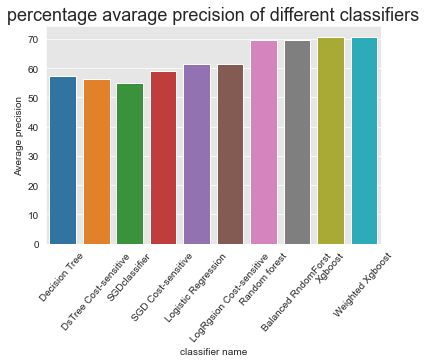

In [345]:

sns.barplot(x= 'index',y=table['Average precision']*100, data = table)
plt.xticks(rotation =49,fontsize =10)
plt.title("percentage avarage precision of different classifiers",fontsize =18 )
plt.xlabel("classifier name")
plt.show()

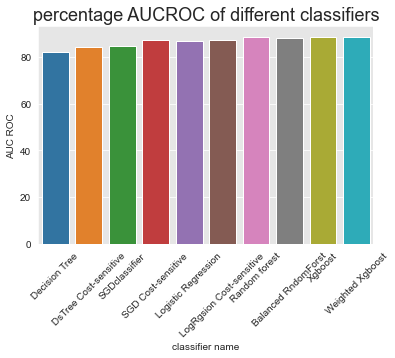

In [346]:
sns.barplot(x= 'index',y=table['AUC ROC']*100, data = table)
plt.xticks(rotation =45)
plt.title("percentage AUCROC of different classifiers",fontsize =18 )
plt.xlabel("classifier name")
plt.show()

In [354]:

table[['index','Average precision']].sort_values(['Average precision'],ascending=False).head(5)

,index,Average precision
8,Xgboost,0.708
9,Weighted Xgboost,0.708
6,Random forest,0.698
7,Balanced RndomForst,0.696
4,Logistic Regression,0.613


In [355]:
table[['index','AUC ROC']].sort_values(['AUC ROC'],ascending=False).head(5)

,index,AUC ROC
8,Xgboost,0.887
9,Weighted Xgboost,0.887
6,Random forest,0.883
7,Balanced RndomForst,0.881
3,SGD Cost-sensitive,0.873


On this simulated dataset, XGBoost provides the highest performances in terms of Average Precision and CP@100, followed by random forest, logistic regression, and finally decision trees which have the lowest performances. The gap in terms of performance is most visible with the average precision metric. The performances of logistic regression, random forest, and XGBoost are very similar in terms of AUC ROC.

In [522]:
#best models parameters

models = [performances_df_rf,performances_df_balanced_rf,performances_df_xgboost,performances_df_weighted_xgboost,performances_df_lr,performances_df_sd]
model_nam = ['performances_df_rf','performances_df_balanced_rf','performances_df_xgboost','performances_df_weighted_xgboost','performances_df_lr','performances_df_sd']

lst = [i.index[np.argmax(i['Average precision'+' Validation'].values)] for i in models]
models_best_parameters = []

for i, j, m in zip(models,lst, model_nam):
    d = {m: i.iloc[j]['Parameters']}
    models_best_parameters.append(d)
models_best_parameters   

[{'performances_df_rf': {'clf__class_weight': {0: 0.5},
   'clf__max_depth': 20,
   'clf__n_estimators': 500,
   'clf__random_state': 0}},
 {'performances_df_balanced_rf': {'clf__max_depth': 20,
   'clf__n_estimators': 500,
   'clf__n_jobs': -1,
   'clf__random_state': 0,
   'clf__sampling_strategy': 0.01}},
 {'performances_df_xgboost': {'clf__learning_rate': 0.3,
   'clf__max_depth': 3,
   'clf__n_estimators': 50,
   'clf__n_jobs': 1,
   'clf__random_state': 0,
   'clf__verbosity': 0}},
 {'performances_df_weighted_xgboost': {'clf__learning_rate': 0.3,
   'clf__max_depth': 3,
   'clf__n_estimators': 50,
   'clf__n_jobs': -1,
   'clf__random_state': 0,
   'clf__scale_pos_weight': 1,
   'random_state': 0}},
 {'performances_df_lr': {'clf__C': 500, 'clf__random_state': 0}},
 {'performances_df_sd': {'clf__alpha': 0.001,
   'clf__class_weight': {0: 0.5},
   'clf__random_state': 0}}]

In [10]:
best_parameters_xgboost = models_best_parameters[2]['performances_df_xgboost']
best_parameters_xgboost

{'clf__learning_rate': 0.3,
 'clf__max_depth': 3,
 'clf__n_estimators': 50,
 'clf__n_jobs': 1,
 'clf__random_state': 0,
 'clf__verbosity': 0}

In [20]:
#train test split

(train_df, test_df)=  get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

X_train =train_df[input_features]
y_train = train_df[output_feature]
X_test  = test_df[input_features]
y_test = test_df[output_feature]

In [11]:
def Best_Classifier( clf,  best_params):
        return clf(**best_params)

In [12]:
def performance_parameters(model, X,y, model_name ):
        
    y_pred = model.predict(X)
    
    y_prob = model.predict_proba(X)
    
    try:
        y_scores = y_prob[:, 1]
    except:
        y_scores = model.decision_function(X)
    
    
    
    auc = roc_auc_score(y, y_scores)
    AP = metrics.average_precision_score(y, y_scores)
    
    prec = precision_score(y, y_pred)
    recal = recall_score(y, y_pred) 
    f1scor = f1_score(y, y_pred)

    CMtrx = confusion_matrix(y,y_pred)
    report = metrics.classification_report(y, y_pred)

    model_and_predictions_dictionary = {'best model': str(model),
                                            "precision":prec,
                                            "recall(sensity)":recal,
                                            "f1-score": f1scor,
                                            "AUC":auc,

                                           }

    performances = pd.DataFrame([[model_name, np.round(prec, 2),np.round(recal, 2),np.round(f1scor, 2),np.round(auc,2),np.round(AP,2)]], 
                               columns=['Best model','Precision','Recall','F1score','AUC','Avarage precision'])
    
    test_prediction = pd.DataFrame()
    test_prediction['Y_test'] = y_test

    test_prediction['Y_pred'] = y_pred
    test_prediction['Y_prob'] = np.round(y_prob[:,1],2)
    

    return CMtrx, performances, report,test_prediction
    
    

    


In [51]:
def model_fit_pridict(clf,best_params, X_train,y_train,X_test,y_test,
                      clf_name,):
    
    
    best_model = Best_Classifier(clf ,best_params)
    
    pipeln = Pipeline([('scale', StandardScaler()), ('clf',best_model)])
    make_pipeline(StandardScaler(),best_model)
    pipeln.fit(X_train,y_train)
    CMtrx, performances, report, test_prediction = performance_parameters(pipeln, X_test,y_test, model_name = clf_name)
    
    file = clf_name  + ".pkl"
    pickle.dump(pipeln, open(file, 'wb'))
    
    return CMtrx, performances, report, test_prediction

In [ ]:
#

In [ ]:
best_parameters_random_forest  = models_best_parameters[0]['performances_df_rf']

In [103]:
best_parameters_random_forest =  {'class_weight': {0: 0.5,1:1},
  'max_depth': 20,
  'n_estimators': 500,
  'random_state': 0}

In [104]:
clf = RandomForestClassifier

best_params = best_parameters_random_forest
clf_name ='RandomForestClassifier'
CMtrx, performances_rf, report, test_prediction = model_fit_pridict(clf,best_params, X_train,y_train,X_test,y_test,clf_name)
                   

In [87]:
print("confusion metrix     \n",CMtrx)
print('classification report   \n', report)
performances_rf

confusion metrix     
 [[57872     7]
 [  190   195]]
classification report   
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     57879
           1       0.97      0.51      0.66       385

    accuracy                           1.00     58264
   macro avg       0.98      0.75      0.83     58264
weighted avg       1.00      1.00      1.00     58264



,Best model,Precision,Recall,F1score,AUC,Avarage precision
0,RandomForestClassifier,0.97,0.51,0.66,0.87,0.67


In [105]:
best_parameters_xgboost =  models_best_parameters[2]['performances_df_xgboost']

In [106]:
clf = xgboost.XGBClassifier

best_params = best_parameters_xgboost
clf_name ='XGBClassifier'
CMtrx, performances_xg, report, test_prediction = model_fit_pridict(clf,best_params, X_train,y_train,X_test,y_test,clf_name)

[00:04:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__n_jobs", "clf__random_state", "clf__verbosity" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [94]:
print("confusion metrix     \n",CMtrx)
print('classification report   \n', report)
performances_xg

confusion metrix     
 [[57867    12]
 [  177   208]]
classification report   
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     57879
           1       0.95      0.54      0.69       385

    accuracy                           1.00     58264
   macro avg       0.97      0.77      0.84     58264
weighted avg       1.00      1.00      1.00     58264



,Best model,Precision,Recall,F1score,AUC,Avarage precision
0,XGBClassifier,0.95,0.54,0.69,0.86,0.64


In [107]:
best_parameters_balanced_randomforest = models_best_parameters[1]['performances_df_balanced_rf']

In [108]:
best_parameters_balanced_randomforest ={'max_depth': 20,
 'n_estimators': 500,
 'n_jobs': -1,
 'random_state': 0,
 'sampling_strategy': 0.01}

In [109]:
clf = imblearn.ensemble.BalancedRandomForestClassifier

best_params = best_parameters_balanced_randomforest
clf_name ='BalancedRandomForestClassifier'
CMtrx, performances_bl_rf, report, test_prediction = model_fit_pridict(clf,best_params, X_train,y_train,X_test,y_test,clf_name)

In [102]:
print("confusion metrix     \n",CMtrx)
print('classification report   \n', report)
performances_bl_rf

confusion metrix     
 [[57872     7]
 [  190   195]]
classification report   
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     57879
           1       0.97      0.51      0.66       385

    accuracy                           1.00     58264
   macro avg       0.98      0.75      0.83     58264
weighted avg       1.00      1.00      1.00     58264



,Best model,Precision,Recall,F1score,AUC,Avarage precision
0,BalancedRandomForestClassifier,0.97,0.51,0.66,0.86,0.67


In [113]:
best_parameters_weighted_xgboost =  models_best_parameters[3]['performances_df_weighted_xgboost']

In [114]:
clf = xgboost.XGBClassifier

best_params = best_parameters_weighted_xgboost
clf_name ='weighted XGBClassifier'
CMtrx, performances_xgwt, report, test_prediction = model_fit_pridict(clf,best_params, X_train,y_train,X_test,y_test,clf_name)


print("confusion metrix     \n",CMtrx)
print('classification report   \n', report)
performances_xgwt

[00:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__n_jobs", "clf__random_state", "clf__scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


confusion metrix     
 [[57867    12]
 [  177   208]]
classification report   
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     57879
           1       0.95      0.54      0.69       385

    accuracy                           1.00     58264
   macro avg       0.97      0.77      0.84     58264
weighted avg       1.00      1.00      1.00     58264



,Best model,Precision,Recall,F1score,AUC,Avarage precision
0,weighted XGBClassifier,0.95,0.54,0.69,0.86,0.64


In [121]:
test_performance = performances_xg.append([performances_xgwt,performances_rf,performances_bl_rf])
test_performance

,Best model,Precision,Recall,F1score,AUC,Avarage precision
0,XGBClassifier,0.95,0.54,0.69,0.86,0.64
0,weighted XGBClassifier,0.95,0.54,0.69,0.86,0.64
0,RandomForestClassifier,0.97,0.51,0.66,0.87,0.67
0,BalancedRandomForestClassifier,0.97,0.51,0.66,0.86,0.67


# comparision of model performances  on test and validation for AP metric

#### model performance on test 

In [125]:
test_performance[['Best model','Avarage precision']]

,Best model,Avarage precision
0,XGBClassifier,0.64
0,weighted XGBClassifier,0.64
0,RandomForestClassifier,0.67
0,BalancedRandomForestClassifier,0.67


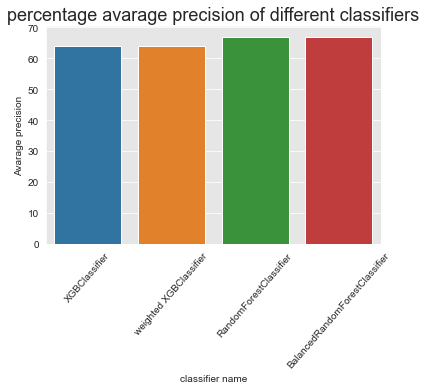

In [129]:

sns.barplot(x= 'Best model',y=test_performance['Avarage precision']*100, data = test_performance)
plt.xticks(rotation =49,fontsize =10)
plt.title("percentage avarage precision of different classifiers",fontsize =18 )
plt.xlabel("classifier name")
plt.show()

#### model performance on validation 

In [354]:
table[['index','Average precision']].sort_values(['Average precision'],ascending=False).head(5)

,index,Average precision
8,Xgboost,0.708
9,Weighted Xgboost,0.708
6,Random forest,0.698
7,Balanced RndomForst,0.696
4,Logistic Regression,0.613


datetime.datetime(2018, 7, 25, 0, 0)

# final grid search for top two models
i have created a saperate note book for grid search and come to the conclusion with bellow best parameters for the respective classifiers.

# stacking

In [25]:
def Best_Classifier( clf,  best_params):
        return clf(**best_params)

# XGBClassifier

In [35]:
best_params = {
                'clf__max_depth': 3,
                'clf__n_estimators': 500,
                'clf__learning_rate': 0.05,
                'clf__random_state': 0,
                'clf__min_child_weight':1,
                'clf__gamma': 0,
                'clf__colsample_bytree':0.9,
                'clf__reg_alpha':1,
                'clf__objective':'binary:logistic',
                
               

            }
clf = xgboost.XGBClassifier

xg = Best_Classifier( clf,  best_params)
xg

pipexg = Pipeline([('scale', StandardScaler()), ('xg',xg)])
pipexg

Pipeline(steps=[('scale', StandardScaler()),
                ('xg',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               clf__colsample_bytree=0.9, clf__gamma=0,
                               clf__learning_rate=0.05, clf__max_depth=3,
                               clf__min_child_weight=1, clf__n_estimators=500,
                               clf__objective='binary:logistic',
                               clf__random_state=0, clf__reg_alpha=1,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None, ...))])

# RandomForestClassifier

In [36]:
best_params = {'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf':1,
 'ccp_alpha':0.0,
 'max_depth':30,
 'bootstrap': True,
  'random_state': 0,
  "criterion"  : "entropy",
   'class_weight':{0: 1},   
             }
clf = RandomForestClassifier

rf = Best_Classifier( clf,  best_params)
rf
piperf = Pipeline([('scale', StandardScaler()), ('rf',rf)])
piperf

Pipeline(steps=[('scale', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight={0: 1},
                                        criterion='entropy', max_depth=30,
                                        min_samples_split=10, n_estimators=800,
                                        random_state=0))])

# GradientBoostingClassifier

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

best_params = {'learning_rate': 0.05,
    'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf':1,
 
 'max_depth':30,

  'random_state': 0,
     
             }

clf = GradientBoostingClassifier
gd = Best_Classifier( clf,  best_params)
gd
pipegd = Pipeline([('scale', StandardScaler()), ('gd',gd)])
pipegd

Pipeline(steps=[('scale', StandardScaler()),
                ('gd',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=30,
                                            min_samples_split=10,
                                            n_estimators=500,
                                            random_state=0))])

# SVC

In [38]:
from sklearn.svm import SVC
best_params = {'random_state': 0,'probability':True,'kernel':'rbf'}
clf = SVC
svc = Best_Classifier( clf,  best_params)
svc
pipesvc = Pipeline([('scale', StandardScaler()), ('svc',svc)])
pipesvc

Pipeline(steps=[('scale', StandardScaler()),
                ('svc', SVC(probability=True, random_state=0))])

In [40]:
from sklearn.ensemble import StackingClassifier

estimators = [
    
    ('prf', piperf),
    ('pgd', pipegd),
    ('psvc', pipesvc),
    
    
]
clf = StackingClassifier( estimators=estimators, final_estimator= pipexg)
clf.fit(X_train,y_train)

[10:59:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__min_child_weight", "clf__n_estimators", "clf__objective", "clf__random_state", "clf__reg_alpha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




StackingClassifier(estimators=[('prf',
                                Pipeline(steps=[('scale', StandardScaler()),
                                                ('rf',
                                                 RandomForestClassifier(class_weight={0: 1},
                                                                        criterion='entropy',
                                                                        max_depth=30,
                                                                        min_samples_split=10,
                                                                        n_estimators=800,
                                                                        random_state=0))])),
                               ('pgd',
                                Pipeline(steps=[('scale', StandardScaler()),
                                                ('gd',
                                                 GradientBoostingClassifier(learning_rate=0.05,
                                                                            max_depth=30,
                                                                            min_samples_spl...
                                                                  colsample_bylevel=None,
                                                                  colsample_bynode=None,
                                                                  colsample_bytree=None,
                                                                  early_stopping_rounds=None,
                                                                  enable_categorical=False,
                                                                  eval_metric=None,
                                                                  gamma=None,
                                                                  gpu_id=None,
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction_constraints=None,
                                                                  learning_rate=None,
                                                                  max_bin=None,
                                                                  max_cat_to_onehot=None,
                                                                  max_delta_step=None,
                                                                  max_depth=None,
                                                                  max_leaves=None,
                                                                  min_child_weight=None, ...))]))

In [41]:
import pickle
pickle.dump(clf, open("Stacking.sav", "wb"))

# prediction on test data

In [ ]:
CMtrx, performances_xg, report, test_prediction = model_fit_pridict(clf,best_params, X_train,y_train,X_test,y_test,clf_name)
print("confusion metrix     \n",CMtrx)
print('classification report   \n', report)
performances_xg

In [79]:
def performance_parameters(model, X,y, model_name ):
        
    y_pred = model.predict(X)
    
    y_prob = model.predict_proba(X)
    
    try:
        y_scores = y_prob[:, 1]
    except:
        y_scores = model.decision_function(X)
    
    
    
    auc = roc_auc_score(y, y_scores)
    AP = metrics.average_precision_score(y, y_scores)
    
    prec = precision_score(y, y_pred)
    recal = recall_score(y, y_pred) 
    f1scor = f1_score(y, y_pred)

    CMtrx = confusion_matrix(y,y_pred)
    report = metrics.classification_report(y, y_pred)

    model_and_predictions_dictionary = {'best model': str(model),
                                            "precision":prec,
                                            "recall(sensity)":recal,
                                            "f1-score": f1scor,
                                            "AUC":auc,

                                           }

    performances = pd.DataFrame([[model_name, np.round(prec, 2),np.round(recal, 2),np.round(f1scor, 2),np.round(auc,2),np.round(AP,2)]], 
                               columns=['Best model','Precision','Recall','F1score','AUC','Avarage precision'])
    
    test_prediction = pd.DataFrame()
    test_prediction['Y_test'] = y

    test_prediction['Y_pred'] = y_pred
    test_prediction['Y_prob'] = np.round(y_prob[:,1],2)
    

    return CMtrx, performances, report,test_prediction
    
    

    


In [45]:
CMtrx, performances, report,test_prediction = performance_parameters(clf, X_test,y_test, model_name= "Stacking")

In [46]:
CMtrx, performances, report,test_prediction = performance_parameters(clf, X_test,y_test, model_name= "Stacking")
print("confusion metrix     \n",CMtrx)
print('classification report   \n', report)
performances

confusion metrix     
 [[57862    17]
 [  166   219]]
classification report   
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     57879
           1       0.93      0.57      0.71       385

    accuracy                           1.00     58264
   macro avg       0.96      0.78      0.85     58264
weighted avg       1.00      1.00      1.00     58264



,Best model,Precision,Recall,F1score,AUC,Avarage precision
0,Stacking,0.93,0.57,0.71,0.87,0.66


In [49]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_DURING_WEEKEND,TX_DURING_NIGHT,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,680886,2018-06-11 00:00:24,3711,8121,75.81,6134424,71,0,0,1,...,34.0,69.421471,124.0,70.598710,2.0,0.0,10.0,0.0,38.0,0.000000
1,680887,2018-06-11 00:00:25,1320,867,101.89,6134425,71,0,0,1,...,27.0,92.666667,117.0,83.699402,1.0,0.0,10.0,0.0,31.0,0.032258
2,680888,2018-06-11 00:01:46,824,7954,44.72,6134506,71,0,0,1,...,23.0,37.035217,80.0,40.290125,2.0,0.0,14.0,0.0,35.0,0.000000
3,680889,2018-06-11 00:02:40,1085,8595,23.08,6134560,71,0,0,1,...,24.0,55.140833,101.0,54.151386,1.0,0.0,8.0,0.0,27.0,0.000000
4,680890,2018-06-11 00:02:55,346,4909,98.13,6134575,71,0,0,1,...,7.0,57.628571,38.0,63.603158,4.0,0.0,13.0,0.0,30.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919762,1600648,2018-09-14 23:56:09,581,1072,44.55,14428569,166,0,0,0,...,15.0,32.692667,62.0,32.186613,1.0,0.0,9.0,0.0,33.0,0.000000
919763,1600649,2018-09-14 23:56:17,3343,7549,50.93,14428577,166,0,0,0,...,30.0,100.098667,94.0,91.341383,0.0,0.0,6.0,0.0,32.0,0.000000
919764,1600650,2018-09-14 23:56:32,1724,2482,24.12,14428592,166,0,0,0,...,23.0,37.620000,81.0,48.893086,2.0,0.0,7.0,0.0,30.0,0.000000
919765,1600651,2018-09-14 23:57:41,760,9688,42.70,14428661,166,0,0,0,...,8.0,81.035000,30.0,81.804333,1.0,0.0,8.0,0.0,36.0,0.000000


# prediction on new data

In [56]:
BEGIN_DATE = "2018-08-15"
END_DATE = "2018-08-21"

DIR_INPUT = "./simulated-data-transformedd/"
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
transactions_df['TX_DATETIME']  = transactions_df.TX_DATETIME.astype("<M8[ns]")
print("Load  files")
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Wall time: 688 ms
Load  files
67049 transactions loaded, containing 594 fraudulent transactions


In [57]:
new_data  = transactions_df[input_features]
new_real_output = transactions_df[output_feature]

In [60]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_DURING_WEEKEND,TX_DURING_NIGHT,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,1303778,2018-08-15 00:00:39,3197,9424,22.43,11750439,136,0,0,1,...,21.0,63.748095,85.0,70.731176,1.0,0.0,11.0,0.0,49.0,0.00000
1,1303779,2018-08-15 00:00:40,2954,4648,70.35,11750440,136,0,0,1,...,11.0,91.099091,78.0,86.743590,0.0,0.0,8.0,0.0,24.0,0.00000
2,1303780,2018-08-15 00:00:51,112,2994,22.20,11750451,136,0,0,1,...,28.0,30.636429,133.0,34.212030,1.0,0.0,10.0,0.0,43.0,0.00000
3,1303781,2018-08-15 00:01:13,3218,4276,96.99,11750473,136,0,0,1,...,24.0,76.391667,93.0,81.349462,1.0,0.0,6.0,0.0,26.0,0.00000
4,1303782,2018-08-15 00:02:19,2475,8738,32.24,11750539,136,0,0,1,...,28.0,57.143929,99.0,60.792222,0.0,0.0,5.0,0.2,25.0,0.84000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67044,1370822,2018-08-21 23:52:54,604,5024,33.02,12354774,142,0,0,0,...,14.0,29.799286,44.0,26.619545,3.0,0.0,9.0,0.0,42.0,0.02381
67045,1370823,2018-08-21 23:53:39,2897,6456,77.65,12354819,142,1,0,0,...,12.0,92.955833,61.0,83.619180,1.0,0.0,7.0,0.0,24.0,0.00000
67046,1370824,2018-08-21 23:55:17,4832,6797,45.77,12354917,142,0,0,0,...,36.0,88.341389,110.0,96.313455,0.0,0.0,8.0,0.0,24.0,0.00000
67047,1370825,2018-08-21 23:55:51,2843,6963,5.38,12354951,142,0,0,0,...,17.0,13.667059,76.0,16.326579,0.0,0.0,9.0,0.0,41.0,0.00000


In [80]:
CMtrx, performances, report,test_prediction = performance_parameters(clf, new_data,new_real_output, model_name= "Stacking")
print("confusion metrix     \n",CMtrx)
print('classification report   \n', report)
performances

confusion metrix     
 [[66408    47]
 [  201   393]]
classification report   
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     66455
           1       0.89      0.66      0.76       594

    accuracy                           1.00     67049
   macro avg       0.95      0.83      0.88     67049
weighted avg       1.00      1.00      1.00     67049



,Best model,Precision,Recall,F1score,AUC,Avarage precision
0,Stacking,0.89,0.66,0.76,0.87,0.7
